**Bayesian Optimisation for hyperparameter configuration**

**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, LSTM 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler  
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
import skopt
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/AFX.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date  Open  High  Low  Close   Volume  Earnings Yield (EY)  \
0 1999-01-01   700   701  700    700        0                 10.2   
1 1999-01-04   680   680  670    670     1500                 10.7   
2 1999-01-05   670   674  665    670    82533                 10.7   
3 1999-01-06   675   700  675    700    32680                 10.2   
4 1999-01-07   710   730  710    730  1457342                  9.8   

   Dividend Yield (DY)  P:E Ratio (P:E) Trades Trade Value  \
0                  5.4         9.803922      -           -   
1                  5.6         9.345794      -           -   
2                  5.6         9.345794      -           -   
3                  5.4         9.803922      -           -   
4                  5.2        10.204082      -           -   

   Total Return Index (TRI)  
0                      80.0  
1                      76.0  
2                      76.0  
3                      80.0  
4                      83.0

**Feature Engineering:**

*   Variations of Log Returns
*   Total Return Index (TRI)
*   Simple Moving Average (SMA) - 20, 50, 200 days
*   Exponentially-weighted Moving Average (EWMA) - 20, 50, 200 days
*   Moving Average Convergence Divergence (MACD)
*   Relative Strength Index (RSI) - 14 days
*   Moving Average Convergence Divergence (MACD)

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
1999-10-14 -0.009050 -0.026668   0.00905   0.00905   0.00905   0.00905   
1999-10-15  0.018019  0.000000  -0.00905   0.00000   0.00000   0.00000   
1999-10-18  0.000000  0.000000   0.00000  -0.00905   0.00000   0.00000   
1999-10-19  0.022473  0.000000   0.00000   0.00000  -0.00905   0.00000   
1999-10-20  0.044452  0.000000   0.00000   0.00000   0.00000  -0.00905   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
1999-10-14  0.057964  0.032314  0.055618   0.040250  ...      0.000000   
1999-10-15  0.032810  0.021543  0.057659   0.032932  ...     -0.026668   
1999-10-18  0.011738  0.014362  0.057659   0.026944  ...      0.000000   
1999-10-19 -0.005334  0.009575  0.055659   0.022045  ...      0.000000   
1999-10-20 -0.005334  0.006383  0.043596   0.018037  ...      0.000000   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
1999-10-14      0.00000     -0.035402           0.009050          0.009050   
1999-10-15      0.00000     -0.026668          -0.026668          0.009050   
1999-10-18      0.00000     -0.022473           0.000000          0.000000   
1999-10-19      0.00000     -0.013544           0.000000          0.000000   
1999-10-20      0.02299      0.004535           0.004535          0.027525   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
1999-10-14           -0.026668            0.009050            0.00905   
1999-10-15            0.009050           -0.035718            0.00000   
1999-10-18            0.000000            0.000000            0.00000   
1999-10-19            0.000000            0.000000            0.00000   
1999-10-20            0.004535            0.000000            0.02299   

            Returns Close/High  Returns Open/Low  
Date                                              
1999-10-14           -0.035402           0.00000  
1999-10-15           -0.035718           0.00905  
1999-10-18           -0.022473           0.00000  
1999-10-19           -0.013544           0.00000  
1999-10-20            0.000000           0.02299  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, x_train, x_val, x_test, sequencelength, scaler):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
    sequencelength - Input sequence length
    scaler - MinMaxScaler used to scale the data
  @returns:
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  return trainingPredictions, valPredictions, testingPredictions

**Parameters for the dataset split**

In [6]:
dataset = df.values
totaldatapoints = len(dataset)
features = len(df.columns) - 1

**Setting up hyperparameter ranges**

In [7]:
dim_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform', name='learning_rate')
dim_num_input_nodes = Integer(low=5, high=256, name='num_input_nodes')
dim_dropout = Real(low=0.0,high=0.25,name='dropout')
dim_sequence_length = Integer(low=100, high=200, name='sequence_length')
dim_batch_size = Integer(low=1, high=250, name='batch_size')

dimensions = [dim_learning_rate,
              dim_num_input_nodes,
              dim_dropout,
              dim_sequence_length,
              dim_batch_size]

default_parameters = [3e-4, 256, 0.2, 200, 32]

**LSTM initialisation based on current set of hyperparameters**

In [8]:
def lstm(learning_rate, num_input_nodes, dropout, sequence_length):
  '''
  Create LSTM
  @params: 
    learning_rate - Adam learning rate
    num_input_nodes - Number of LSTM cells in the layers
    dropout - dropout regularisation
    sequence_length - Length of the input sequence length
  @returns:
    model - Compiled LSTM
  '''
  #Construct LSTM
  model = Sequential()
  model.add(LSTM(units=num_input_nodes, return_sequences=True, input_shape=(sequence_length, features)))
  model.add(LSTM(units=num_input_nodes, dropout=dropout))
  model.add(Dense(1))

  adam = Adam(lr=learning_rate, amsgrad=True)
  model.compile(optimizer=adam, loss='mae', metrics=['mse','mae','mape'])
  return model

**Train LSTM with current hyperparameters**

In [9]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_input_nodes, dropout, sequence_length, batch_size):
  '''
  Used in the Bayesian Optimisation Procedure
  @params:
    learning_rate - Adam learning rate
    num_input_nodes - Number of GRU cells in the layers
    dropout - dropout regularisation
    sequence_length - Length of the input sequence length
    batch_size - Model batch size
  @returns:
    mse - Mean squared Error using current hyperparameters
  '''
  #Get train, val, test split
  #Window Variables
  start = 0 + sequence_length
  trainingSize = 1000
  validationSize = 100
  testingSize = 150
  end = start + trainingSize + validationSize + testingSize + sequence_length

  #Get Data split
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequence_length, features, scaler, start, trainingSize, validationSize, testingSize, end)
  
  print()
  print('learning rate: {}'.format(learning_rate))
  print('num_input_nodes: {}'.format(num_input_nodes))
  print('dropout: {}'.format(dropout))
  print('sequence_length : {}'.format(sequence_length))
  print('batch_size: {}'.format(batch_size))
  print()

  model = lstm(learning_rate=learning_rate,
               num_input_nodes=num_input_nodes,
               dropout=dropout,
               sequence_length=sequence_length)
  
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  blackbox = model.fit(x_train, y_train,  batch_size=batch_size, epochs=150, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./LSTM.h5')
  
  _, _, testingPredictions = makePredictions(model, x_train, x_val, x_test, sequence_length, scaler)

  #Plot graph of forecasts
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['Test Predictions'] = testingPredictions
  testGraph['Test Actual'] = y_test

  plt.figure(figsize=(16,8))
  plt.plot(testGraph['Test Actual'], label='True values')
  plt.plot(testGraph['Test Predictions'], label = 'Predicted Values')
  plt.title("Result")
  plt.legend(loc = 'best')
  plt.show()

  #Get mse on the test set
  mse = mean_squared_error(y_test, testingPredictions)

  # Print the classification accuracy.
  print()
  print("MSE: {}".format(mse))
  print()

  del model
  K.clear_session()
  tf.compat.v1.reset_default_graph()
  return mse

**Bayesian Optimisation**

Iteration No: 1 started. Evaluating function at provided point.

learning rate: 0.0003
num_input_nodes: 256
dropout: 0.2
sequence_length : 200
batch_size: 32



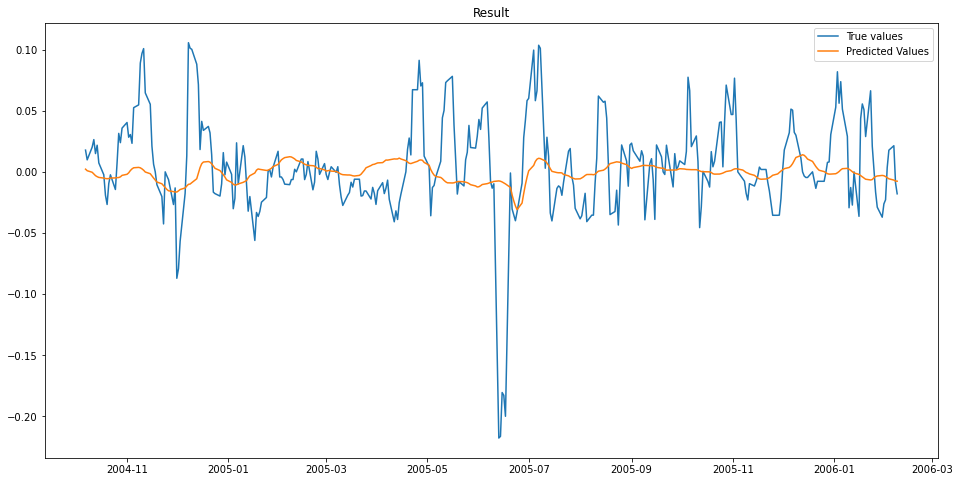


MSE: 0.0016907486256175323

Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 38.0306
Function value obtained: 0.0017
Current minimum: 0.0017
Iteration No: 2 started. Evaluating function at random point.

learning rate: 0.003918194347141745
num_input_nodes: 51
dropout: 0.19492275006819237
sequence_length : 160
batch_size: 112



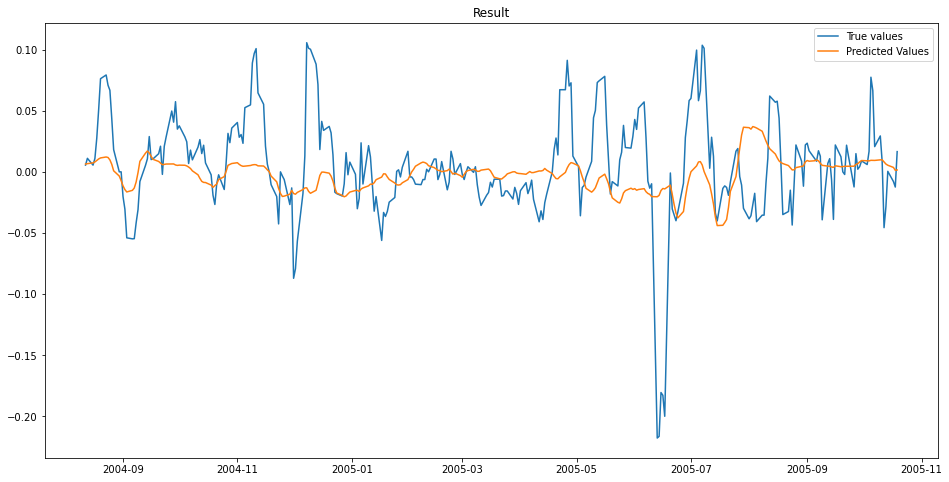


MSE: 0.0018332964260434096

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 11.9254
Function value obtained: 0.0018
Current minimum: 0.0017
Iteration No: 3 started. Evaluating function at random point.

learning rate: 0.00015847101210439096
num_input_nodes: 120
dropout: 0.08342715278475547
sequence_length : 114
batch_size: 163



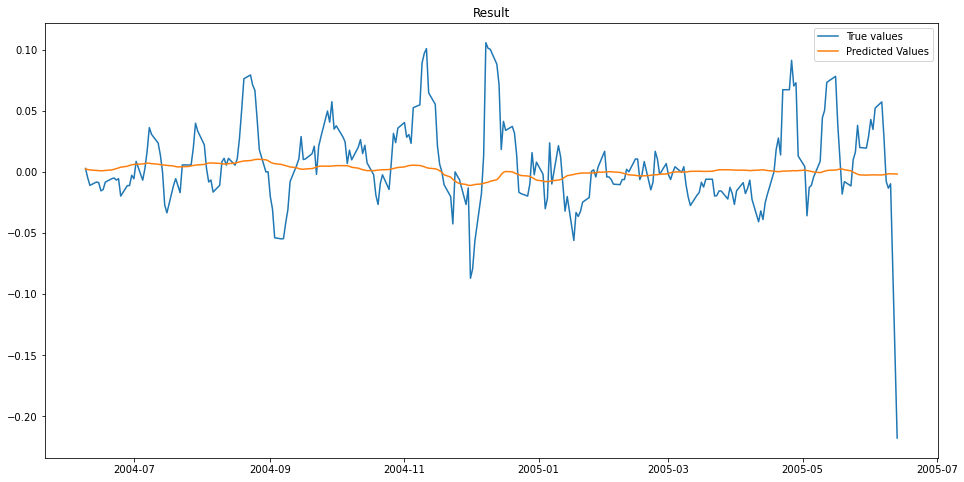


MSE: 0.0012116654156652167

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.6326
Function value obtained: 0.0012
Current minimum: 0.0012
Iteration No: 4 started. Evaluating function at random point.

learning rate: 0.00012966511753760403
num_input_nodes: 186
dropout: 0.2346381772539376
sequence_length : 100
batch_size: 248



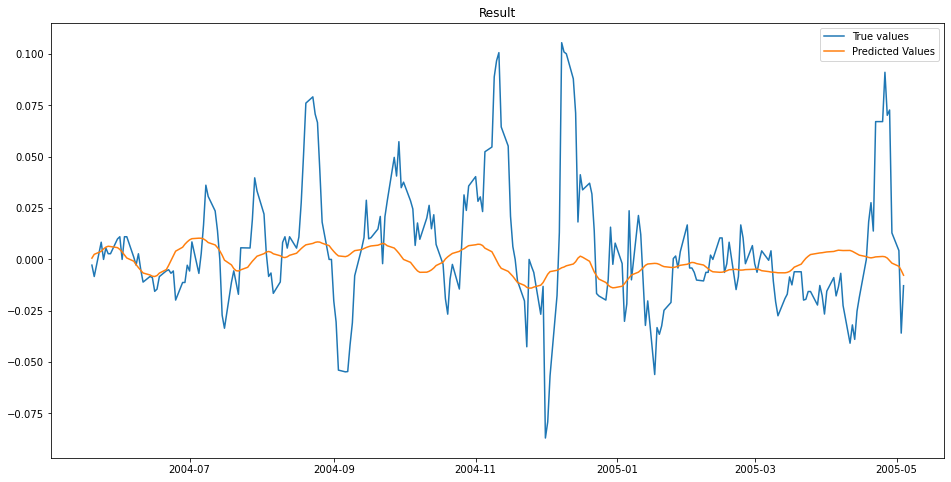


MSE: 0.0009473145400365205

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 12.6088
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 5 started. Evaluating function at random point.

learning rate: 0.0017177621112338384
num_input_nodes: 159
dropout: 0.001766576304929352
sequence_length : 102
batch_size: 132



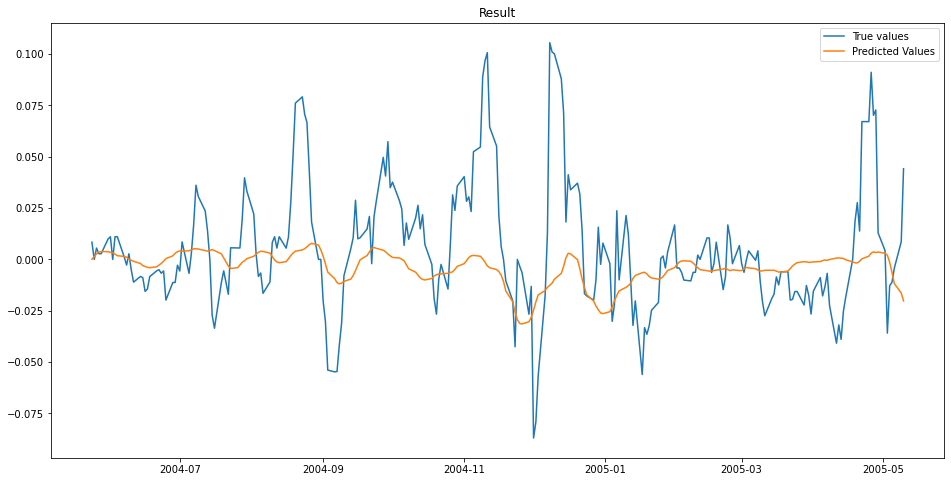


MSE: 0.0009749589947158619

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 10.6873
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 6 started. Evaluating function at random point.

learning rate: 0.0006305535040199287
num_input_nodes: 17
dropout: 0.24343887971036485
sequence_length : 123
batch_size: 24



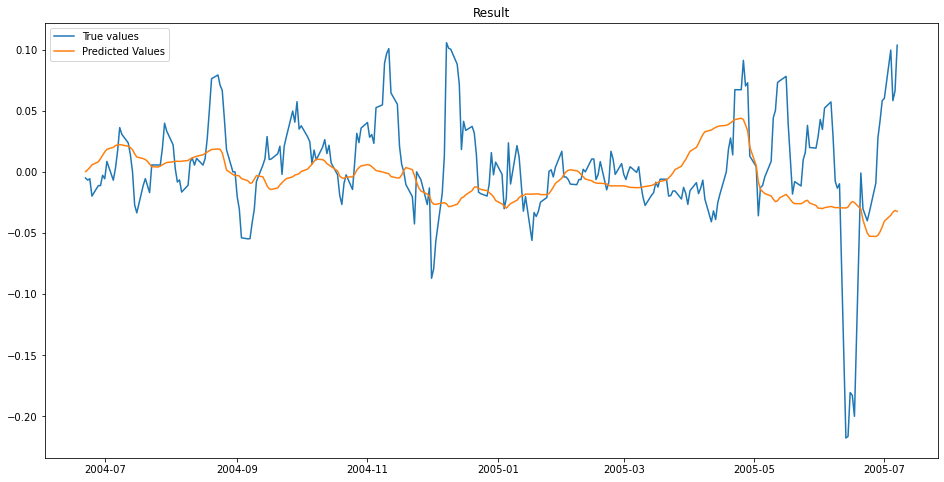


MSE: 0.002192943155326877

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 29.2763
Function value obtained: 0.0022
Current minimum: 0.0009
Iteration No: 7 started. Evaluating function at random point.

learning rate: 0.0017249321573178998
num_input_nodes: 101
dropout: 0.2458077214516971
sequence_length : 147
batch_size: 215



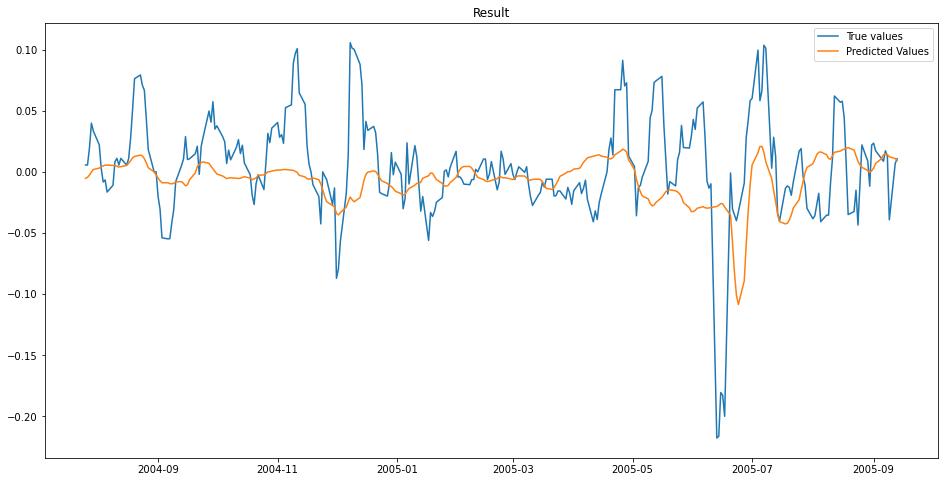


MSE: 0.001954317763730797

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 13.8246
Function value obtained: 0.0020
Current minimum: 0.0009
Iteration No: 8 started. Evaluating function at random point.

learning rate: 0.0022941144328643983
num_input_nodes: 118
dropout: 0.003316240289966633
sequence_length : 194
batch_size: 141



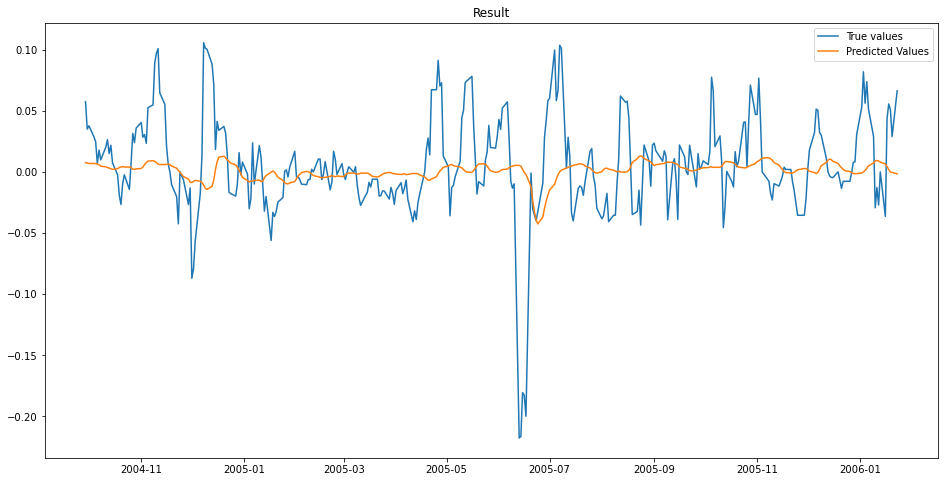


MSE: 0.0018027130398955407

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 14.2566
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 9 started. Evaluating function at random point.

learning rate: 0.0005899741796710488
num_input_nodes: 9
dropout: 0.05772345640553726
sequence_length : 124
batch_size: 171



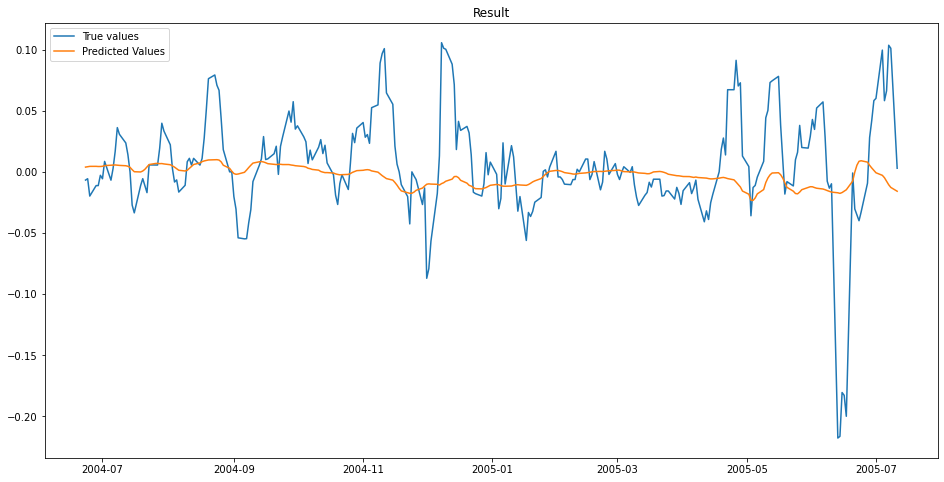


MSE: 0.0019119188802136338

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 11.1533
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 10 started. Evaluating function at random point.

learning rate: 0.0016595613641357258
num_input_nodes: 214
dropout: 0.04334116337694303
sequence_length : 139
batch_size: 46



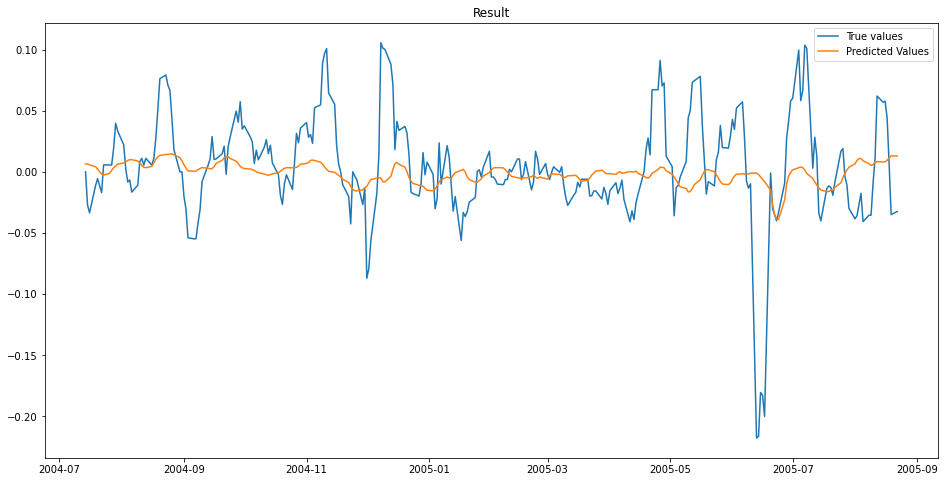


MSE: 0.0018682423874317022

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 21.7010
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 11 started. Evaluating function at random point.

learning rate: 0.0032413268041956303
num_input_nodes: 112
dropout: 0.05198541571704722
sequence_length : 157
batch_size: 9



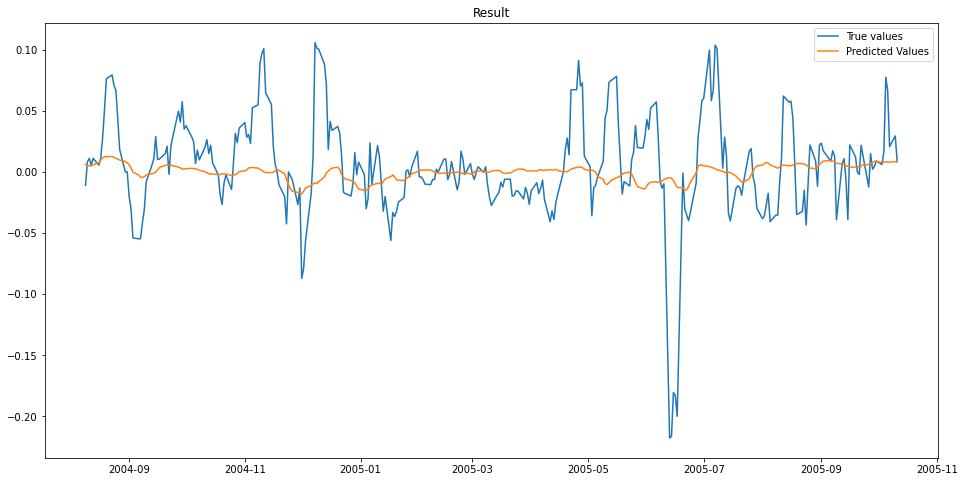


MSE: 0.0017818808985351508

Iteration No: 11 ended. Evaluation done at random point.
Time taken: 49.8194
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 12 started. Evaluating function at random point.

learning rate: 0.0005832015322806523
num_input_nodes: 244
dropout: 0.21073127747973497
sequence_length : 170
batch_size: 242



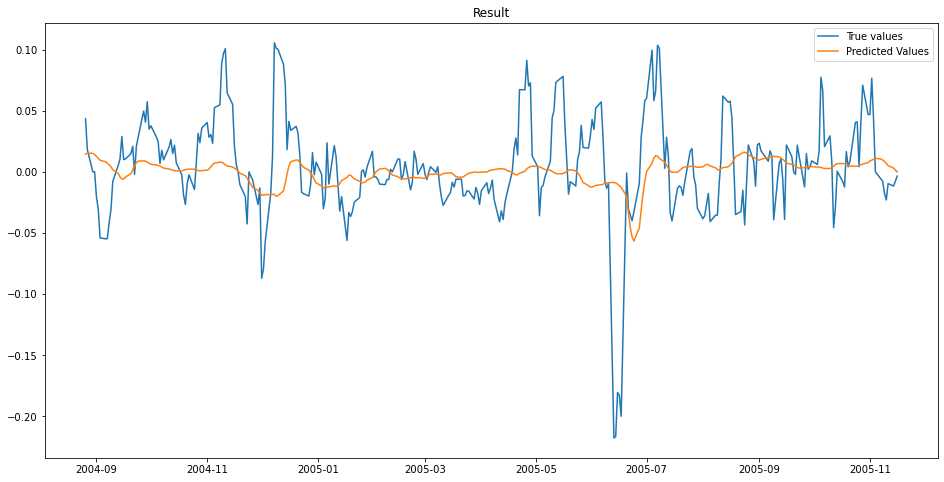


MSE: 0.001752575608290979

Iteration No: 12 ended. Evaluation done at random point.
Time taken: 18.7812
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 13 started. Searching for the next optimal point.

learning rate: 0.0011055354209093056
num_input_nodes: 247
dropout: 0.23961521562344856
sequence_length : 105
batch_size: 66



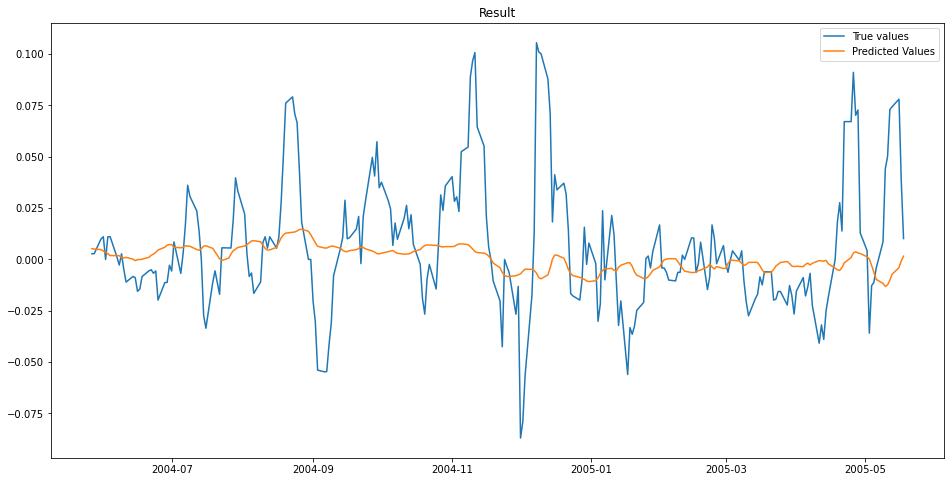


MSE: 0.0010225912358686486

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 20.2618
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 14 started. Searching for the next optimal point.

learning rate: 0.0002050670804560787
num_input_nodes: 240
dropout: 0.23434029225351388
sequence_length : 141
batch_size: 44



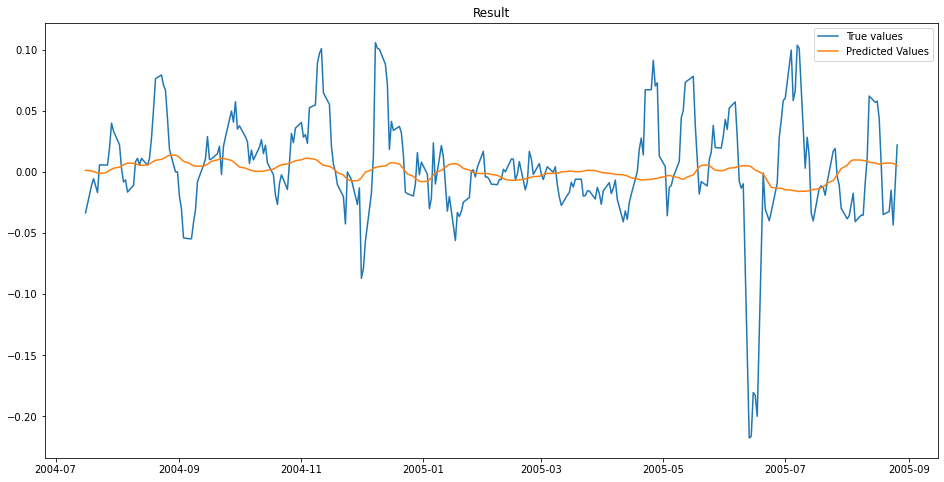


MSE: 0.0019702657374109974

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 21.1749
Function value obtained: 0.0020
Current minimum: 0.0009
Iteration No: 15 started. Searching for the next optimal point.

learning rate: 0.00010993676976866407
num_input_nodes: 98
dropout: 0.19810399992331712
sequence_length : 151
batch_size: 140



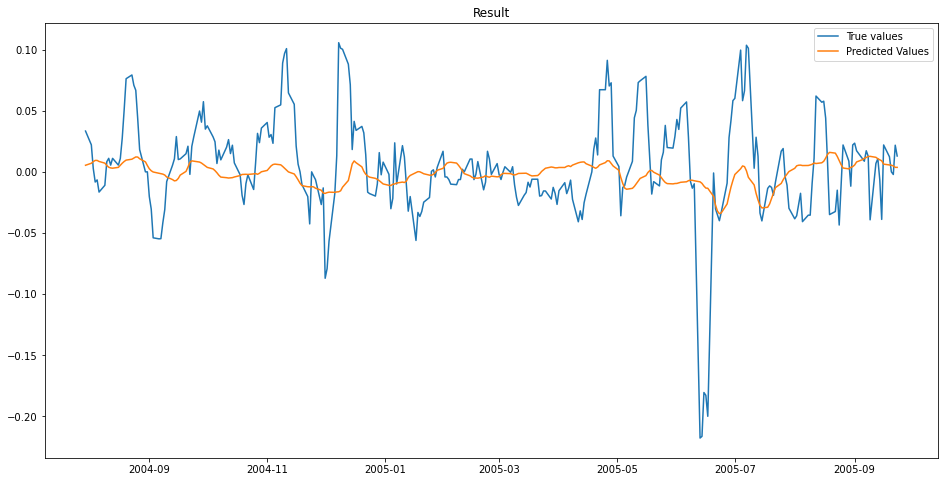


MSE: 0.0018119495702584862

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 17.2528
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 16 started. Searching for the next optimal point.

learning rate: 0.0001040887456555644
num_input_nodes: 228
dropout: 0.1383620356395441
sequence_length : 150
batch_size: 41



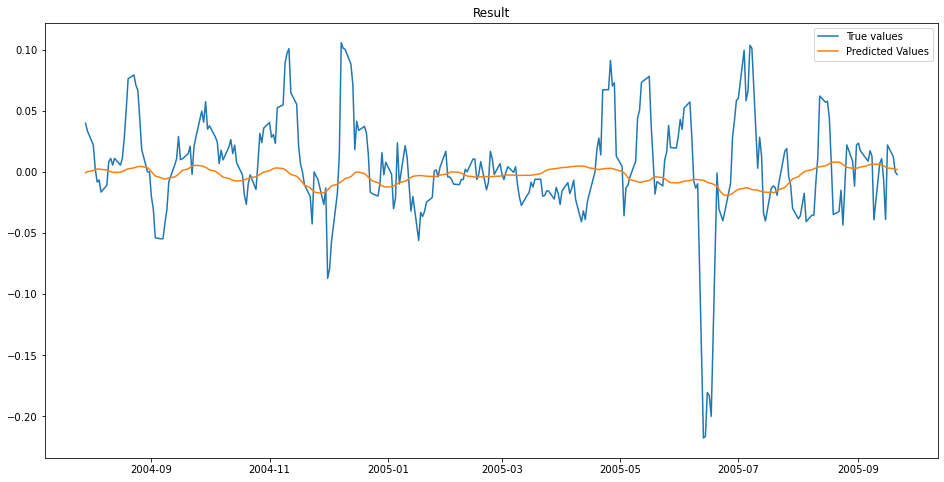


MSE: 0.001899909588979258

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 22.8942
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 17 started. Searching for the next optimal point.

learning rate: 0.00011184685970357246
num_input_nodes: 122
dropout: 0.128318518509429
sequence_length : 181
batch_size: 4



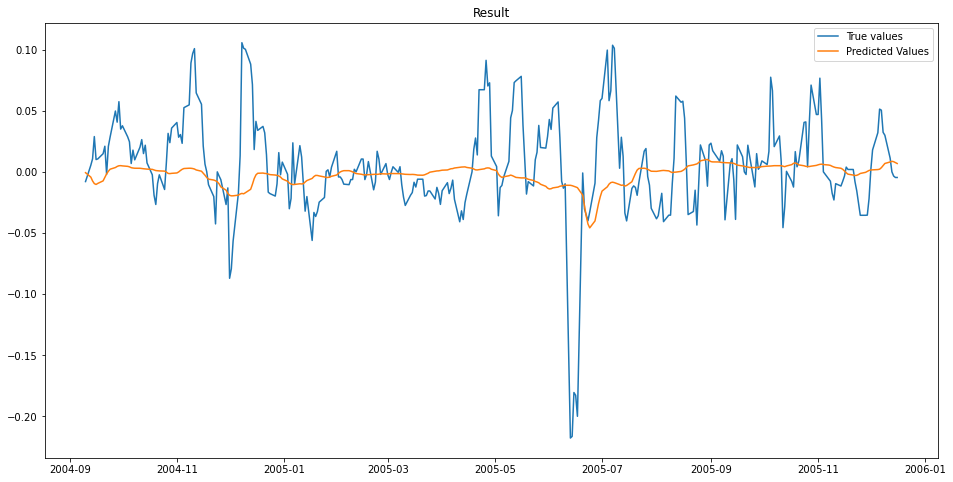


MSE: 0.0017485073926451903

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 105.3134
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 18 started. Searching for the next optimal point.

learning rate: 0.0001
num_input_nodes: 256
dropout: 0.0
sequence_length : 100
batch_size: 168



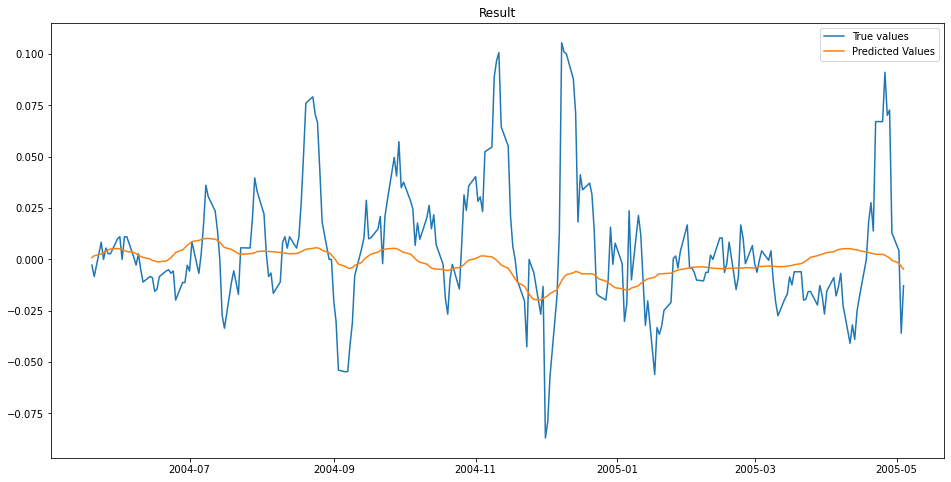


MSE: 0.000956778044016544

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 12.8723
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 19 started. Searching for the next optimal point.

learning rate: 0.0001375647966095774
num_input_nodes: 233
dropout: 0.0
sequence_length : 107
batch_size: 169



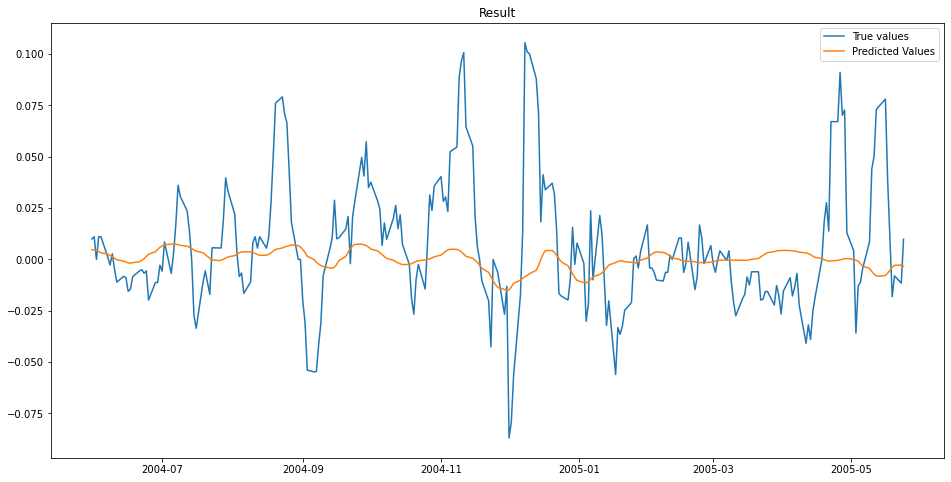


MSE: 0.0010312472178975528

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 13.1372
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 20 started. Searching for the next optimal point.

learning rate: 0.01
num_input_nodes: 221
dropout: 0.11869087188274181
sequence_length : 100
batch_size: 209



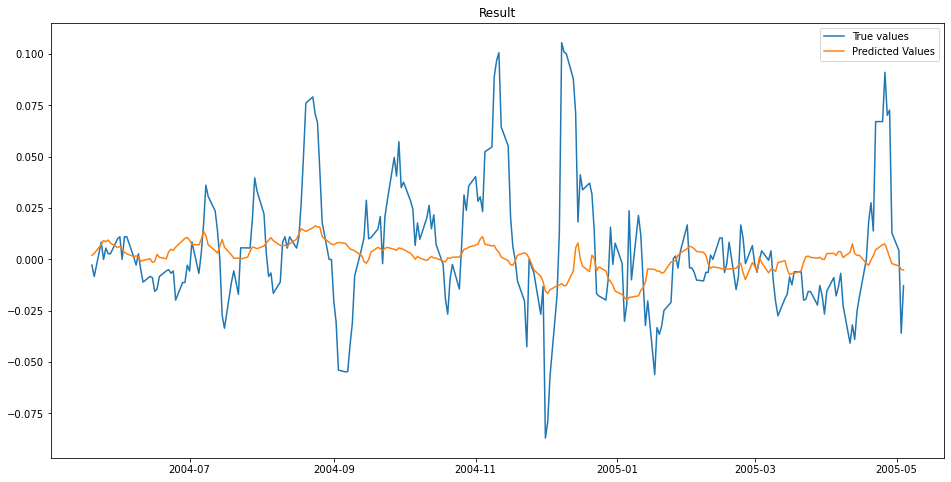


MSE: 0.000922824695369384

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 13.4151
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 21 started. Searching for the next optimal point.

learning rate: 0.01
num_input_nodes: 22
dropout: 0.25
sequence_length : 100
batch_size: 1



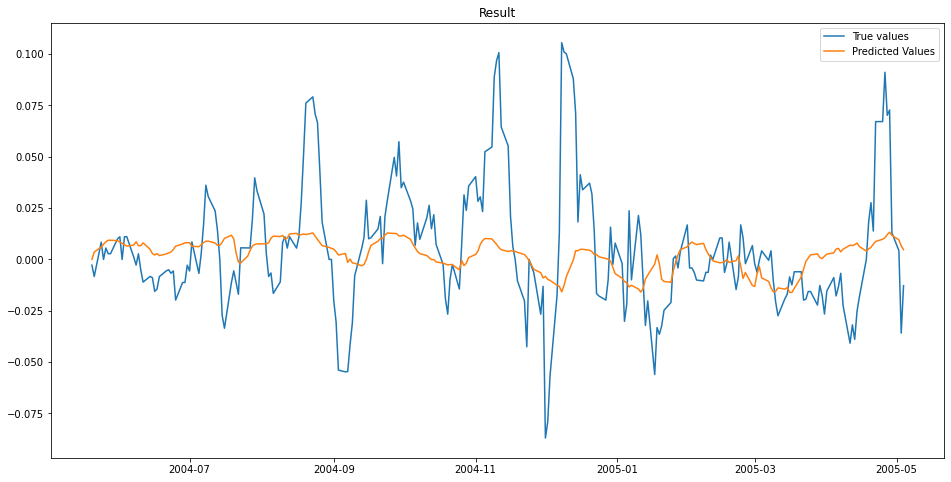


MSE: 0.0008931056795964858

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 228.8656
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 22 started. Searching for the next optimal point.

learning rate: 0.01
num_input_nodes: 53
dropout: 0.25
sequence_length : 110
batch_size: 250



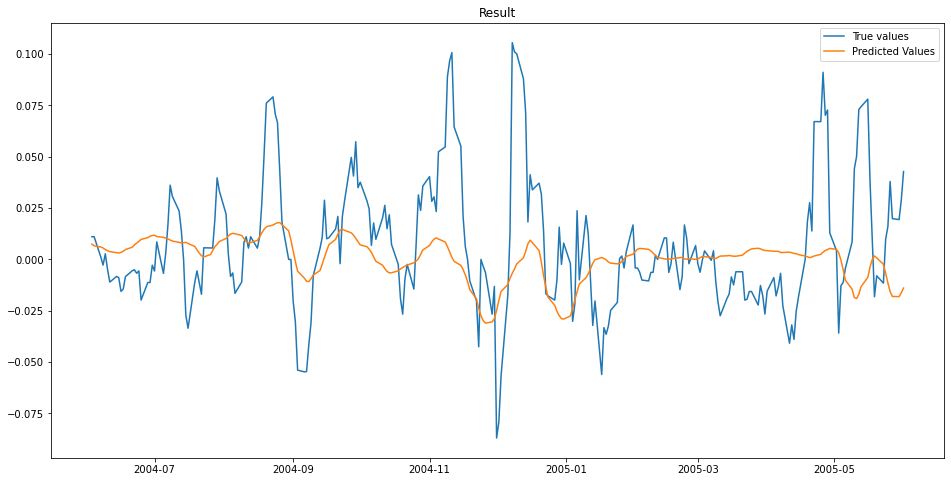


MSE: 0.001028310587501194

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 9.2276
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 23 started. Searching for the next optimal point.

learning rate: 0.0008702141964891654
num_input_nodes: 114
dropout: 0.21218122653025484
sequence_length : 123
batch_size: 245



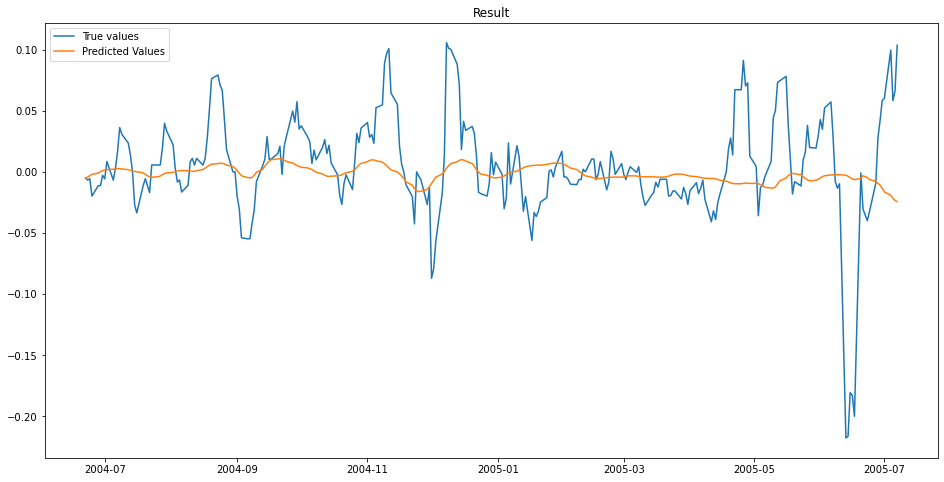


MSE: 0.0019203293021597691

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 11.0965
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 24 started. Searching for the next optimal point.

learning rate: 0.01
num_input_nodes: 208
dropout: 0.0324908659471185
sequence_length : 100
batch_size: 1



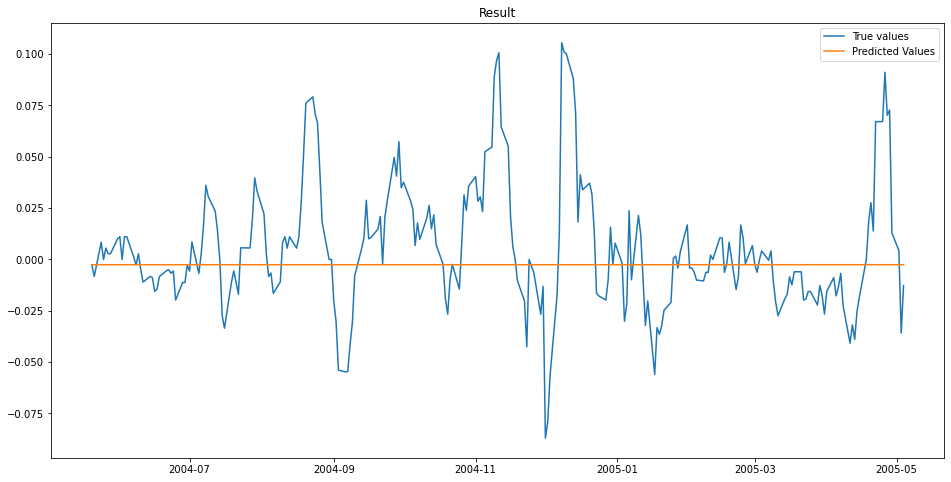


MSE: 0.0010211502826421284

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 403.3946
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 25 started. Searching for the next optimal point.

learning rate: 0.0002858844098343165
num_input_nodes: 124
dropout: 0.19871927528155914
sequence_length : 112
batch_size: 17



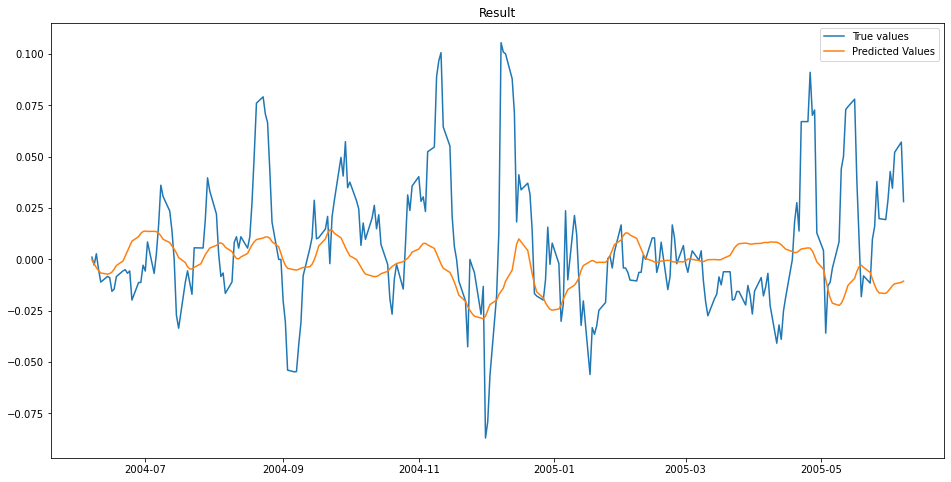


MSE: 0.0011365244449634572

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 26.5298
Function value obtained: 0.0011
Current minimum: 0.0009
Iteration No: 26 started. Searching for the next optimal point.

learning rate: 0.006290897685896966
num_input_nodes: 5
dropout: 0.0
sequence_length : 100
batch_size: 250



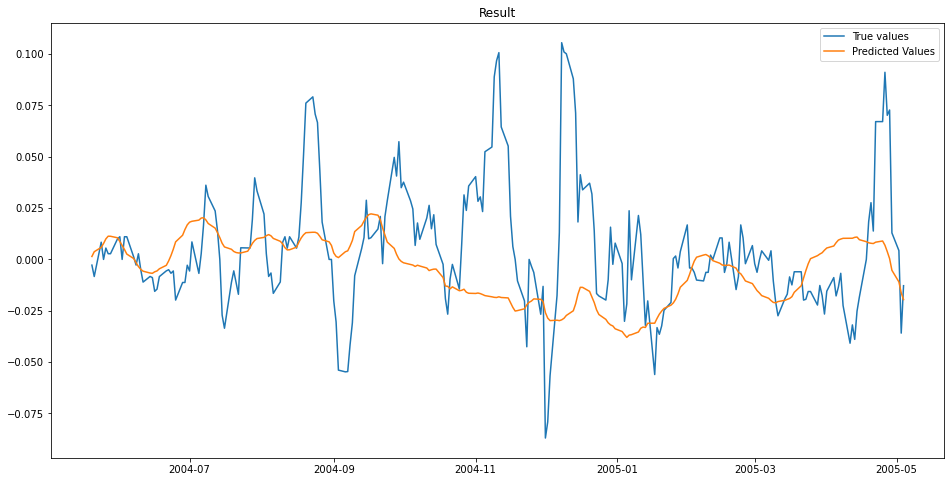


MSE: 0.001223083342911232

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 9.5367
Function value obtained: 0.0012
Current minimum: 0.0009
Iteration No: 27 started. Searching for the next optimal point.

learning rate: 0.00391989751341379
num_input_nodes: 67
dropout: 0.22209883733973426
sequence_length : 161
batch_size: 144



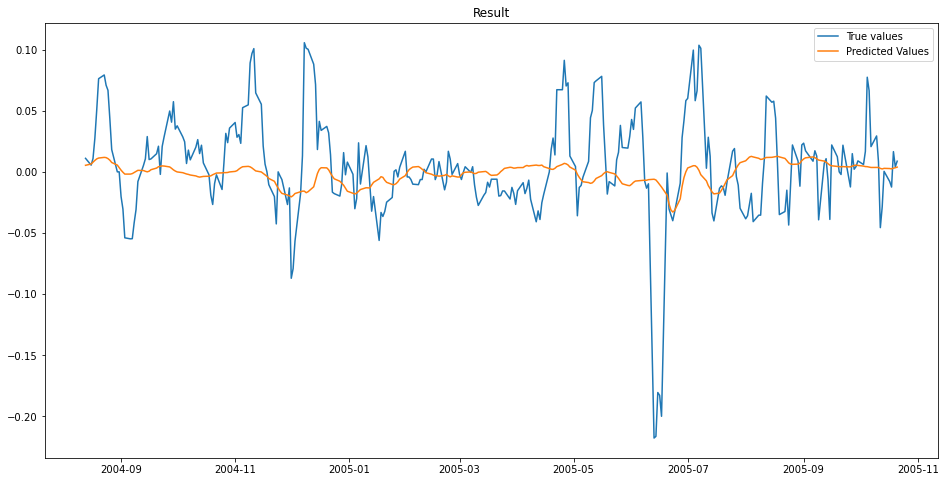


MSE: 0.0017986272766742572

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 12.1025
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 28 started. Searching for the next optimal point.

learning rate: 0.0022506529857244336
num_input_nodes: 161
dropout: 0.08522162464234627
sequence_length : 155
batch_size: 198



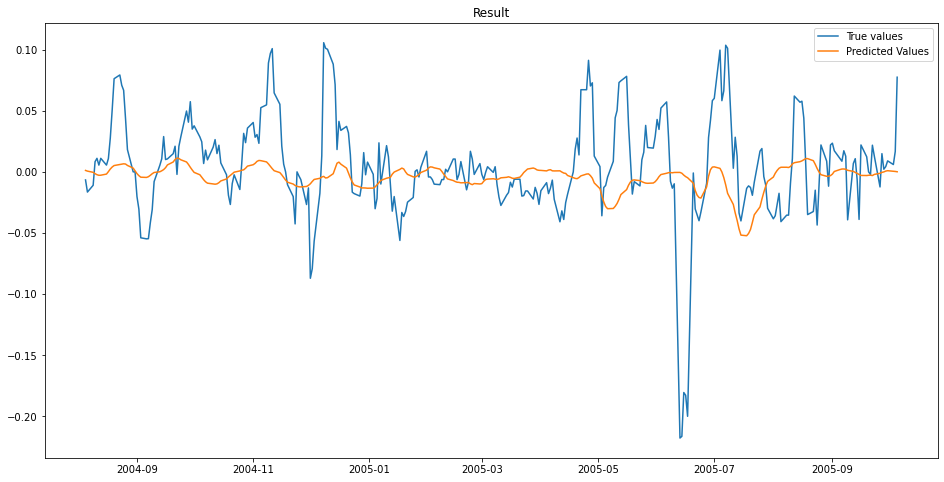


MSE: 0.0019320664127335104

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 15.3659
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 29 started. Searching for the next optimal point.

learning rate: 0.00043407796537720076
num_input_nodes: 207
dropout: 0.05111844448881574
sequence_length : 187
batch_size: 195



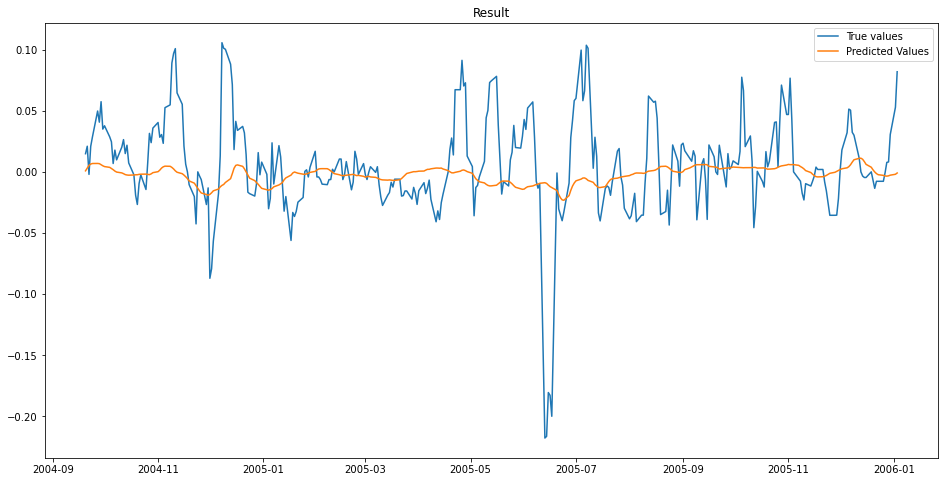


MSE: 0.0017042147805911155

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 17.4552
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 30 started. Searching for the next optimal point.

learning rate: 0.0020071857054210717
num_input_nodes: 53
dropout: 0.15903945320548288
sequence_length : 110
batch_size: 151



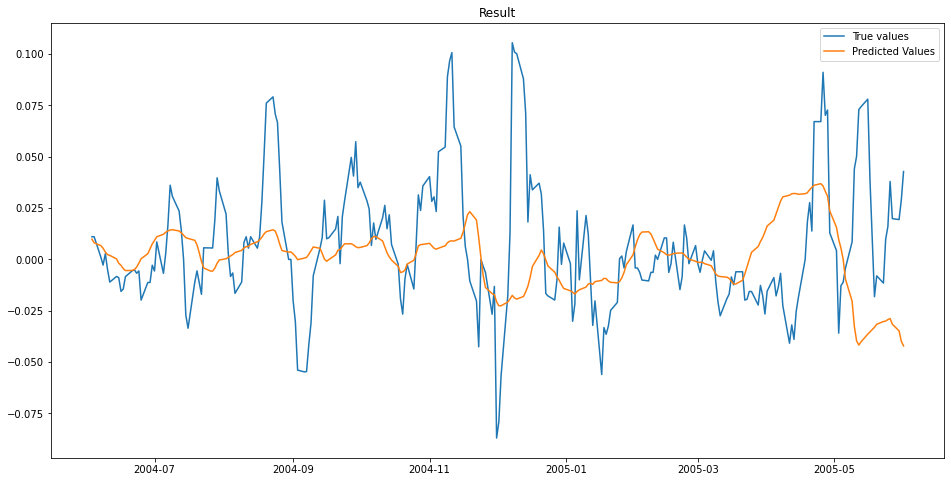


MSE: 0.0012665015925265263

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 12.3096
Function value obtained: 0.0013
Current minimum: 0.0009
Iteration No: 31 started. Searching for the next optimal point.

learning rate: 0.0017560590100163395
num_input_nodes: 197
dropout: 0.1088747643186341
sequence_length : 121
batch_size: 65



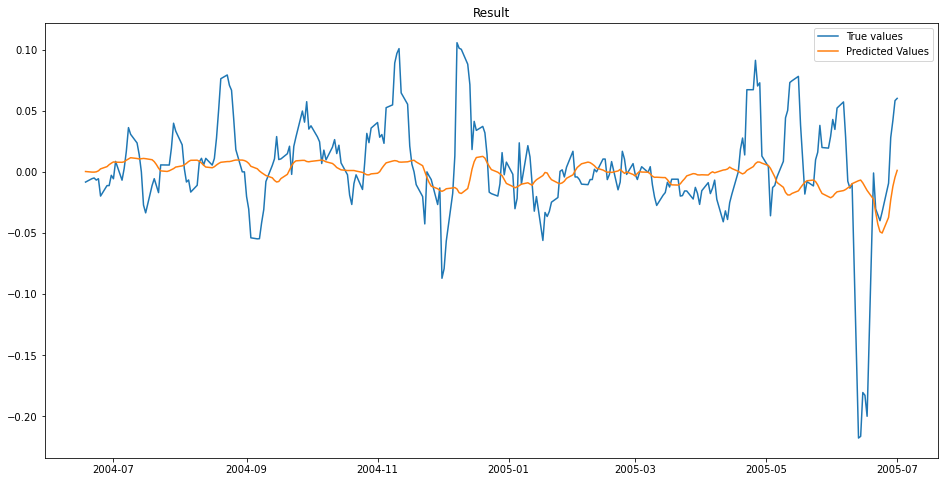


MSE: 0.0018082950050148914

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 19.9108
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 32 started. Searching for the next optimal point.

learning rate: 0.0008633902007401385
num_input_nodes: 127
dropout: 0.008028454523932834
sequence_length : 176
batch_size: 126



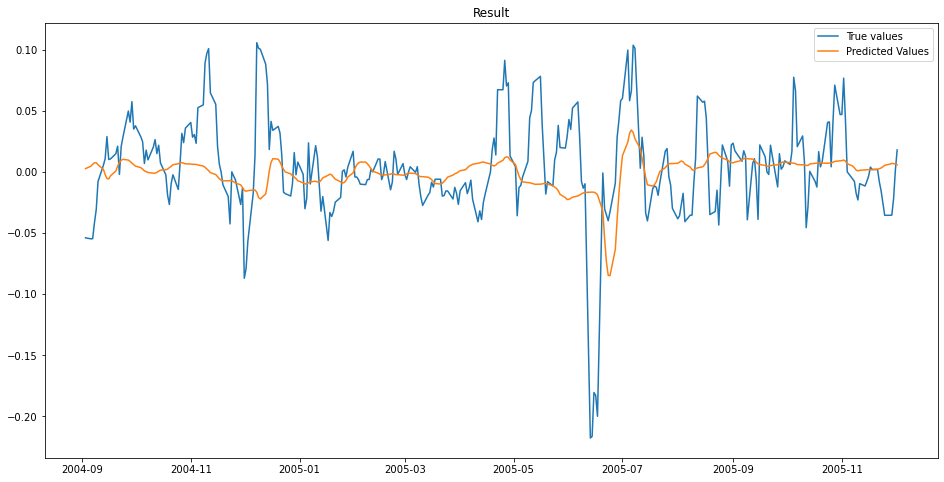


MSE: 0.001708674862852504

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 16.5116
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 33 started. Searching for the next optimal point.

learning rate: 0.0003125732810502738
num_input_nodes: 52
dropout: 0.11887285405944947
sequence_length : 158
batch_size: 179



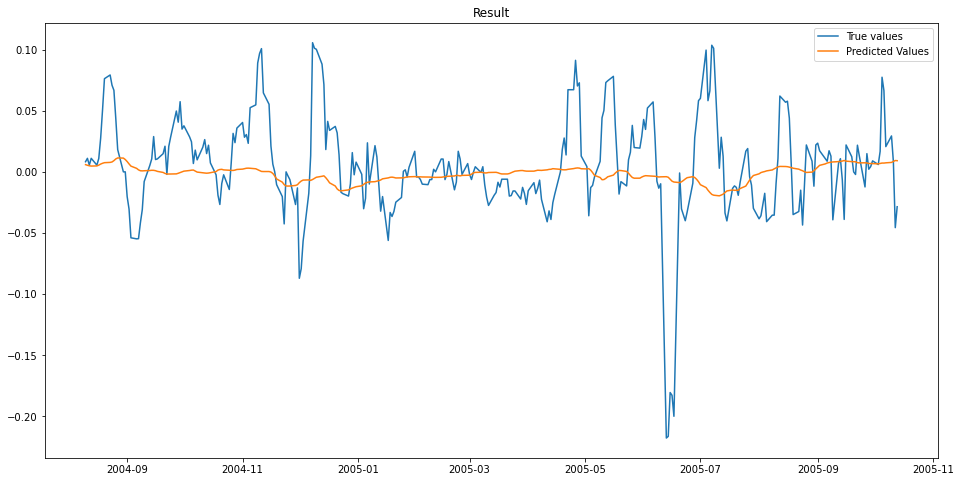


MSE: 0.0018930747572699887

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 11.6763
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 34 started. Searching for the next optimal point.

learning rate: 0.00022184183289896374
num_input_nodes: 96
dropout: 0.011921636836763397
sequence_length : 129
batch_size: 205



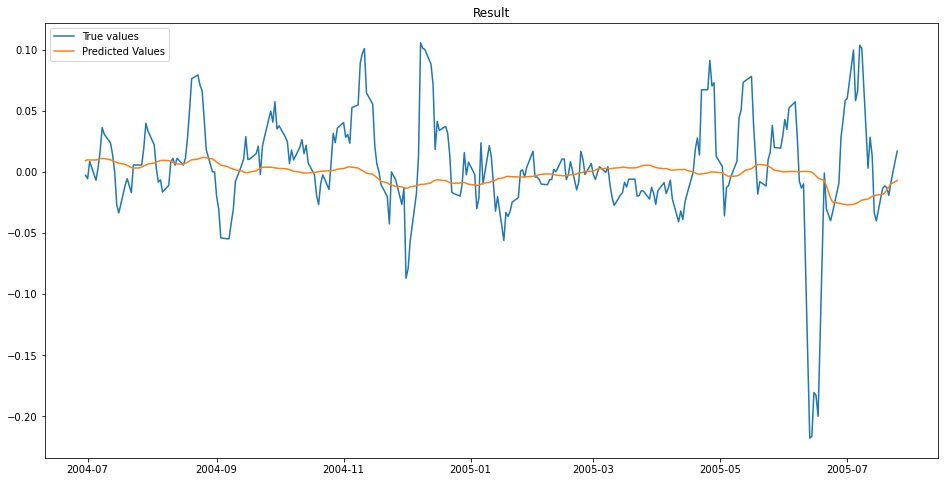


MSE: 0.0020348508146450007

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 10.8928
Function value obtained: 0.0020
Current minimum: 0.0009
Iteration No: 35 started. Searching for the next optimal point.

learning rate: 0.006166599651395621
num_input_nodes: 256
dropout: 0.25
sequence_length : 100
batch_size: 63



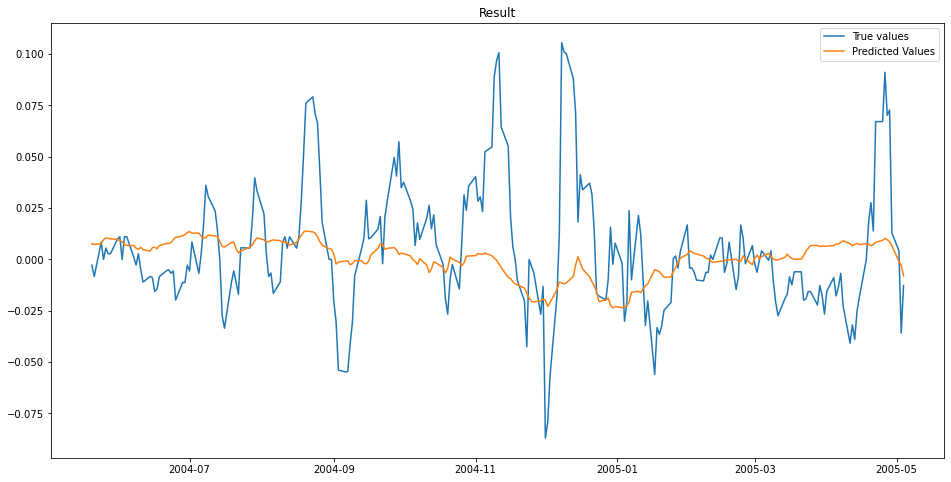


MSE: 0.0009629276427351866

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 16.6381
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 36 started. Searching for the next optimal point.

learning rate: 0.0002895922946094357
num_input_nodes: 256
dropout: 0.25
sequence_length : 103
batch_size: 168



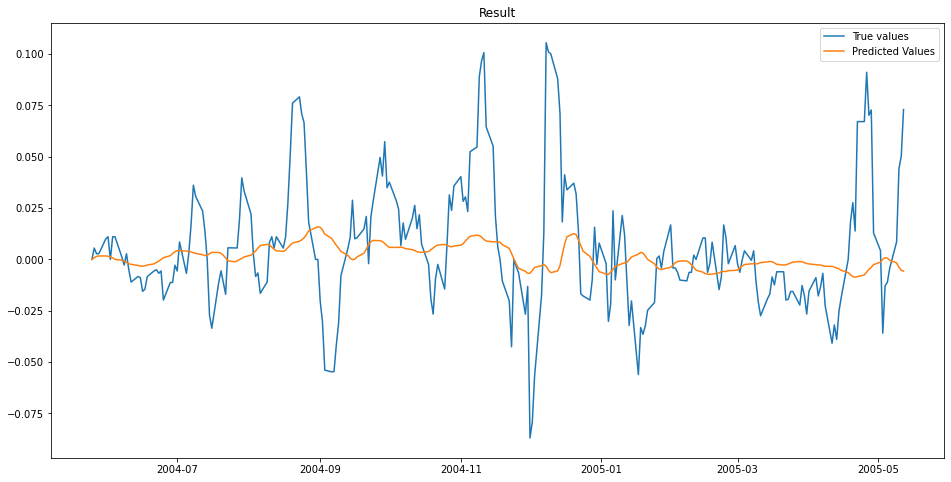


MSE: 0.0009736814508979745

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 13.0281
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 37 started. Searching for the next optimal point.

learning rate: 0.00012480426334935394
num_input_nodes: 256
dropout: 0.25
sequence_length : 100
batch_size: 124



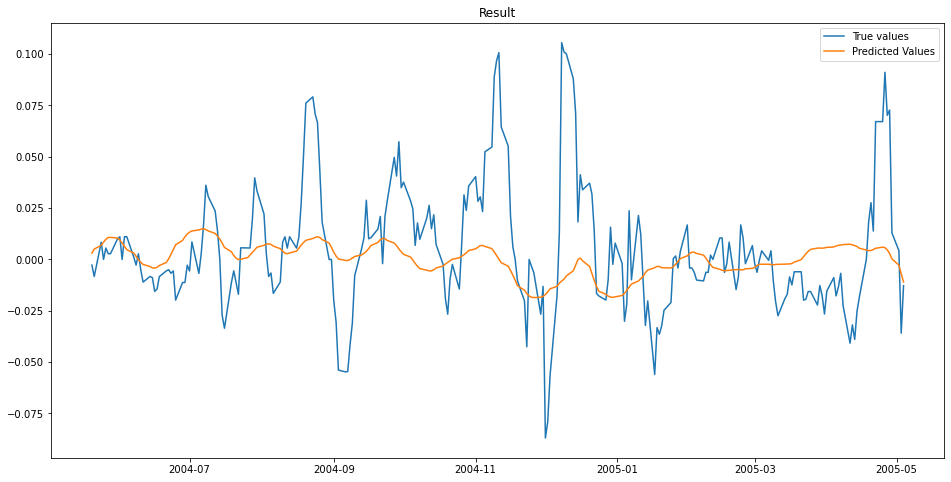


MSE: 0.000937740370725224

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 15.3977
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 38 started. Searching for the next optimal point.

learning rate: 0.001385168775294796
num_input_nodes: 149
dropout: 0.04594948359045937
sequence_length : 114
batch_size: 57



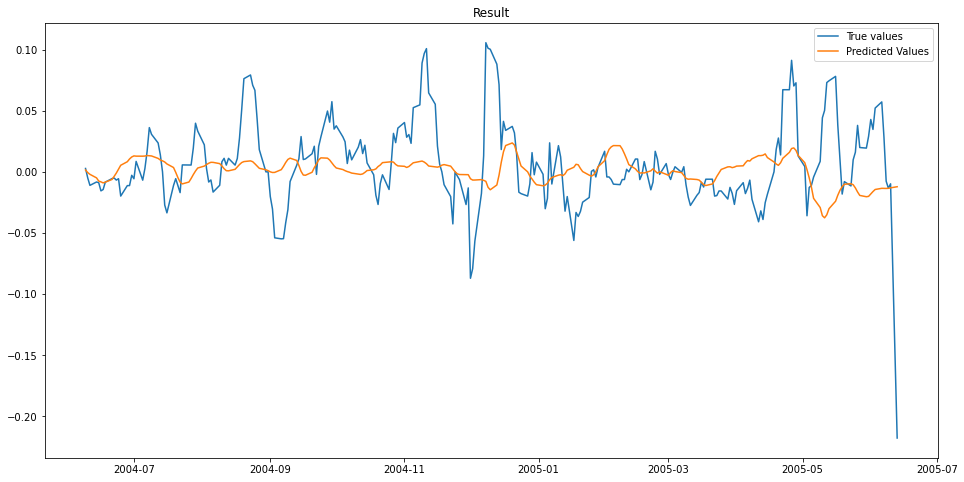


MSE: 0.0013525077384657538

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 19.4136
Function value obtained: 0.0014
Current minimum: 0.0009
Iteration No: 39 started. Searching for the next optimal point.

learning rate: 0.008510984339216363
num_input_nodes: 6
dropout: 0.05192338510125548
sequence_length : 118
batch_size: 2



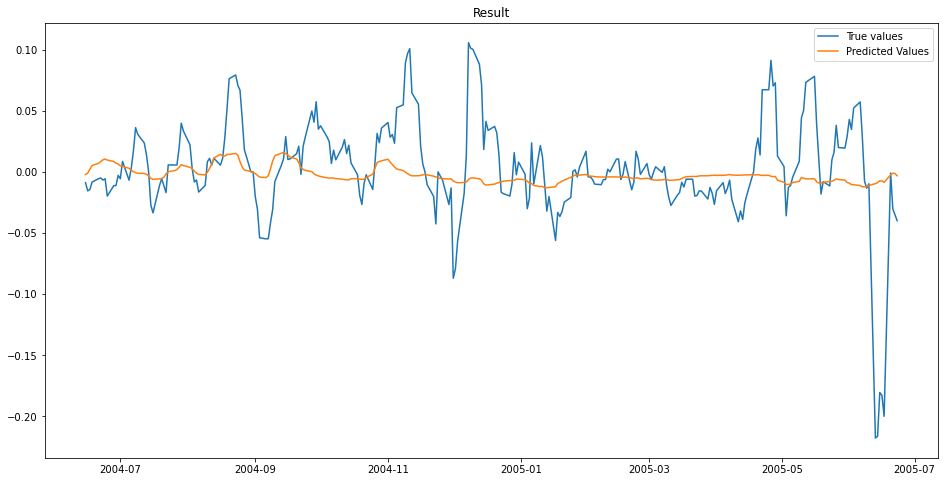


MSE: 0.0017647078192639446

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 122.4648
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 40 started. Searching for the next optimal point.

learning rate: 0.00025023919664219615
num_input_nodes: 244
dropout: 0.1194401150232195
sequence_length : 114
batch_size: 166



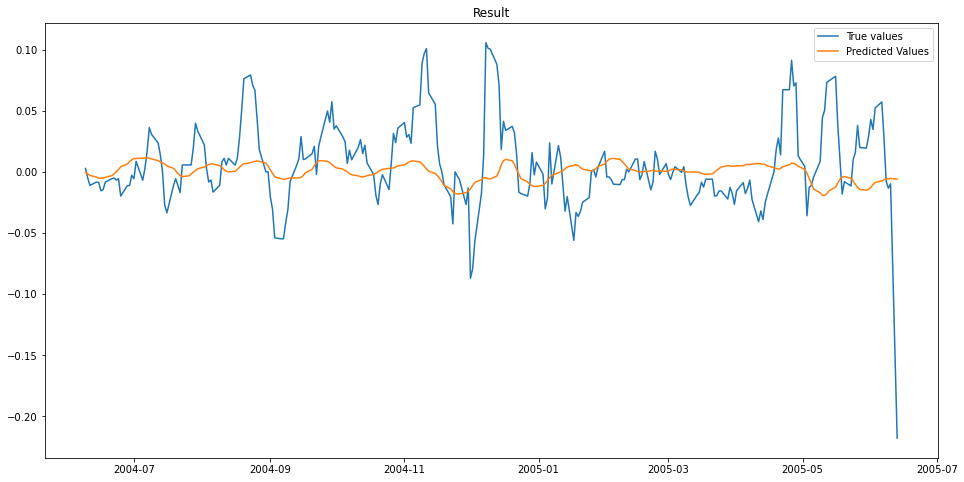


MSE: 0.0012555201444482643

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 16.2346
Function value obtained: 0.0013
Current minimum: 0.0009
Iteration No: 41 started. Searching for the next optimal point.

learning rate: 0.0006916911497906814
num_input_nodes: 142
dropout: 0.18595234380023104
sequence_length : 166
batch_size: 109



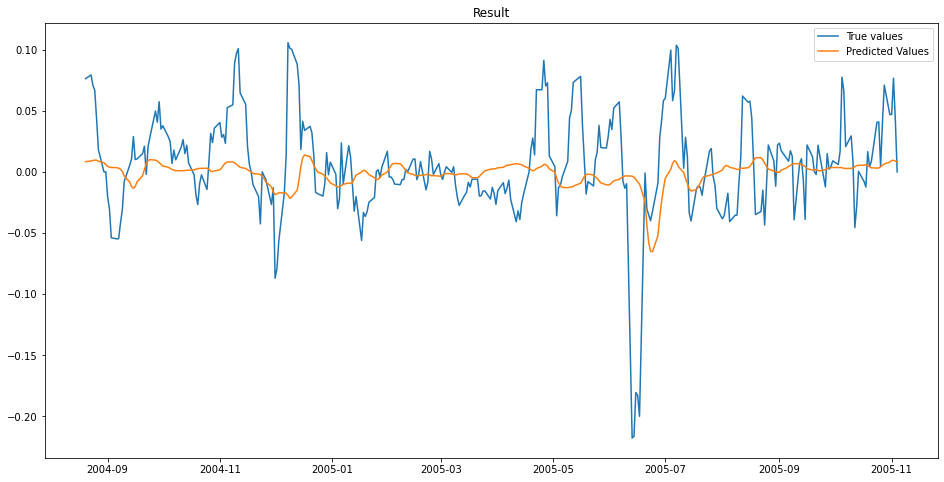


MSE: 0.0018772511938423577

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 15.9416
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 42 started. Searching for the next optimal point.

learning rate: 0.006257393327206118
num_input_nodes: 86
dropout: 0.12898899378067608
sequence_length : 178
batch_size: 185



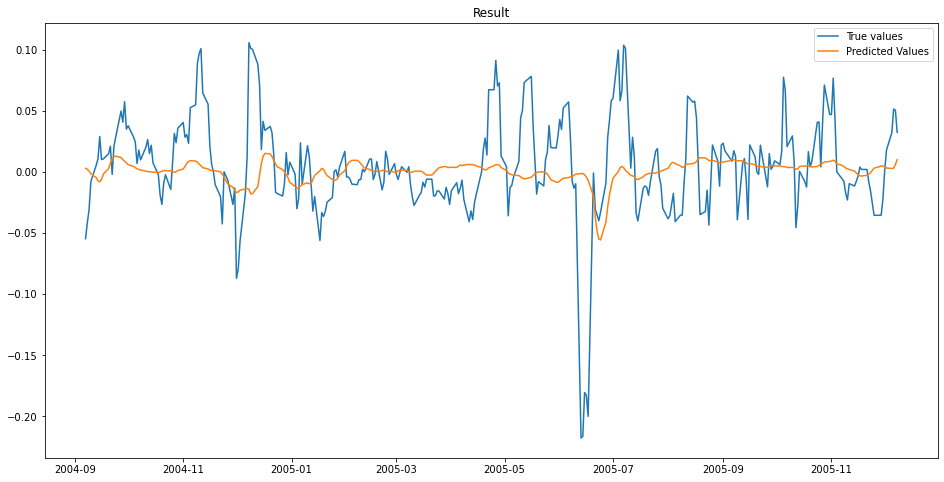


MSE: 0.0017453474460811707

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 13.6094
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 43 started. Searching for the next optimal point.

learning rate: 0.0016479398738448868
num_input_nodes: 256
dropout: 0.25
sequence_length : 100
batch_size: 1



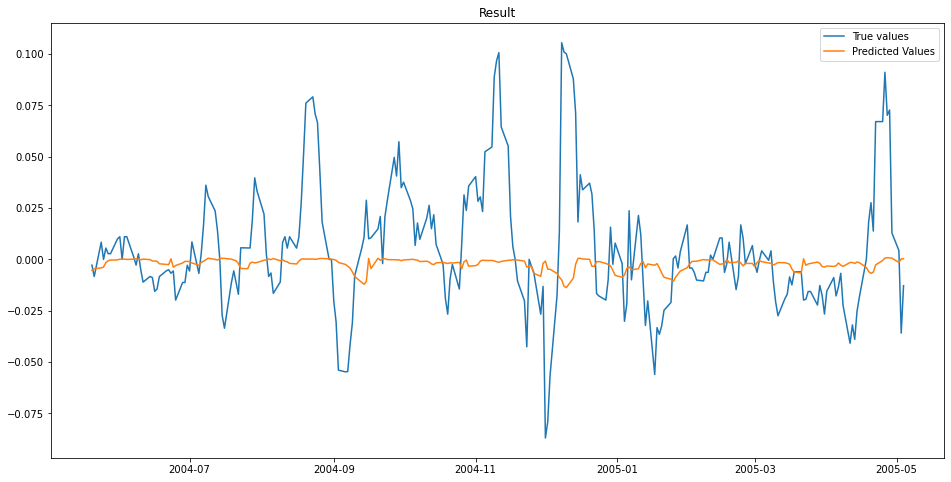


MSE: 0.0010186073093680491

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 333.0267
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 44 started. Searching for the next optimal point.

learning rate: 0.00015999394011370437
num_input_nodes: 181
dropout: 0.08604513919744848
sequence_length : 110
batch_size: 34



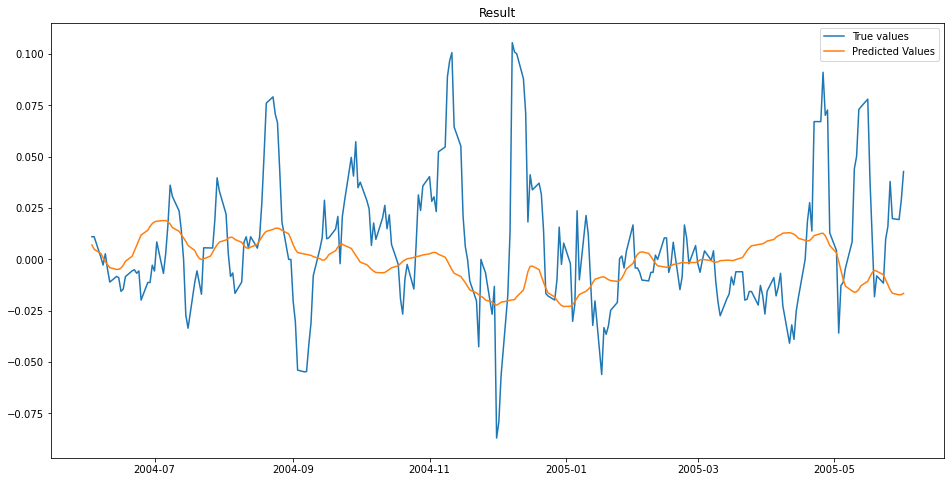


MSE: 0.001152405427282478

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 23.9045
Function value obtained: 0.0012
Current minimum: 0.0009
Iteration No: 45 started. Searching for the next optimal point.

learning rate: 0.002576050711952346
num_input_nodes: 217
dropout: 0.18008333534734158
sequence_length : 187
batch_size: 33



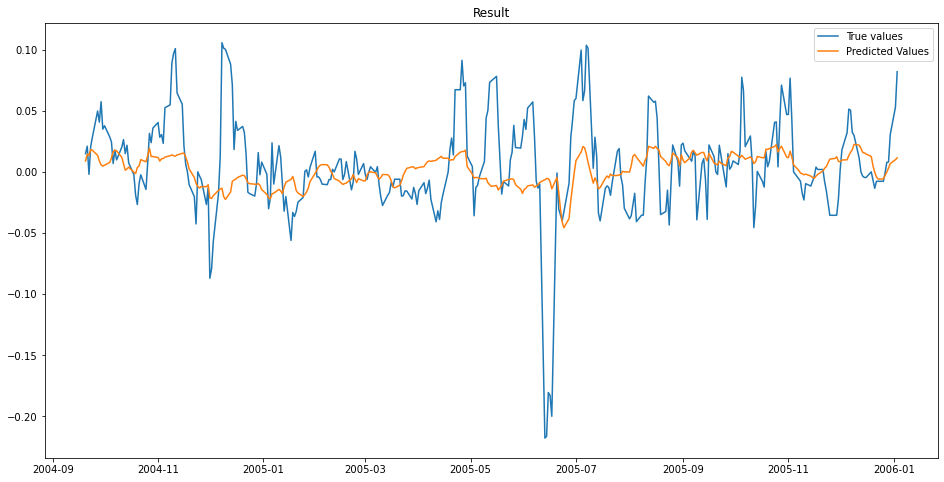


MSE: 0.0015920020731537733

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 51.2005
Function value obtained: 0.0016
Current minimum: 0.0009
Iteration No: 46 started. Searching for the next optimal point.

learning rate: 0.0036879818841733195
num_input_nodes: 88
dropout: 0.24555595662566815
sequence_length : 165
batch_size: 41



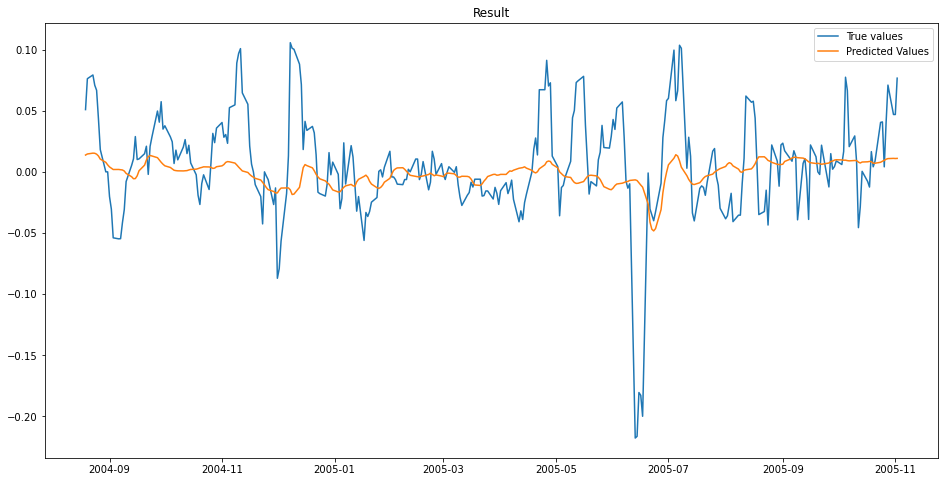


MSE: 0.0017812662992116582

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 19.8584
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 47 started. Searching for the next optimal point.

learning rate: 0.00011635407776633327
num_input_nodes: 92
dropout: 0.19701404602314318
sequence_length : 157
batch_size: 26



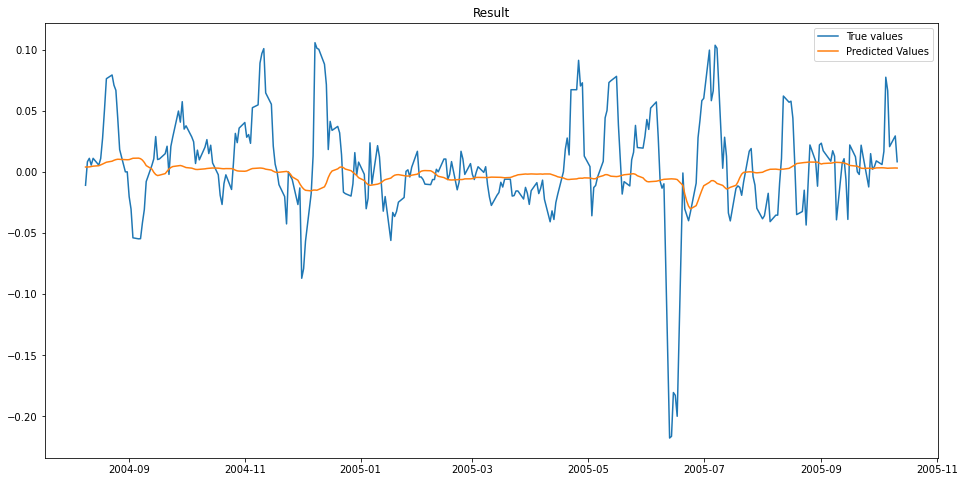


MSE: 0.0019039960539649968

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 24.1639
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 48 started. Searching for the next optimal point.

learning rate: 0.00098393071892428
num_input_nodes: 216
dropout: 0.0919402180489166
sequence_length : 168
batch_size: 52



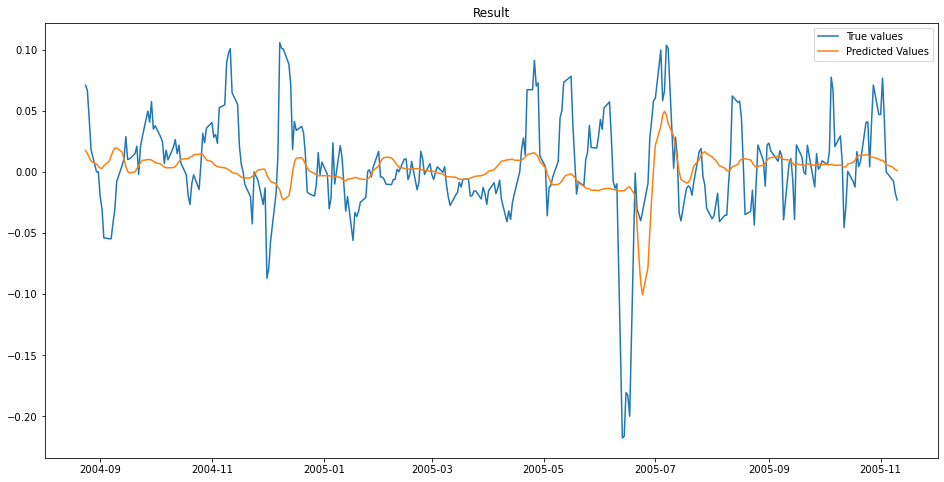


MSE: 0.0017426178048974559

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 23.4586
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 49 started. Searching for the next optimal point.

learning rate: 0.005545635250694995
num_input_nodes: 130
dropout: 0.25
sequence_length : 102
batch_size: 250



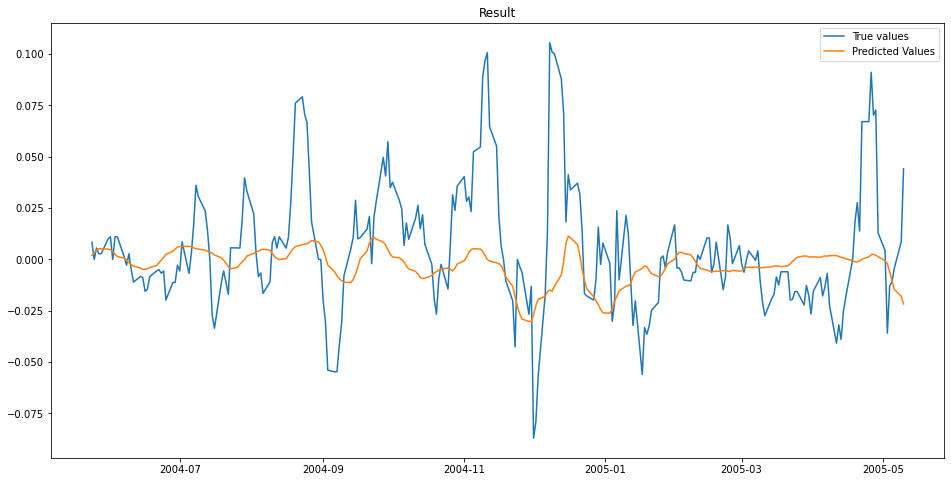


MSE: 0.0009588785510444078

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 10.9478
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 50 started. Searching for the next optimal point.

learning rate: 0.0015196648522700794
num_input_nodes: 144
dropout: 0.12923914683506915
sequence_length : 107
batch_size: 181



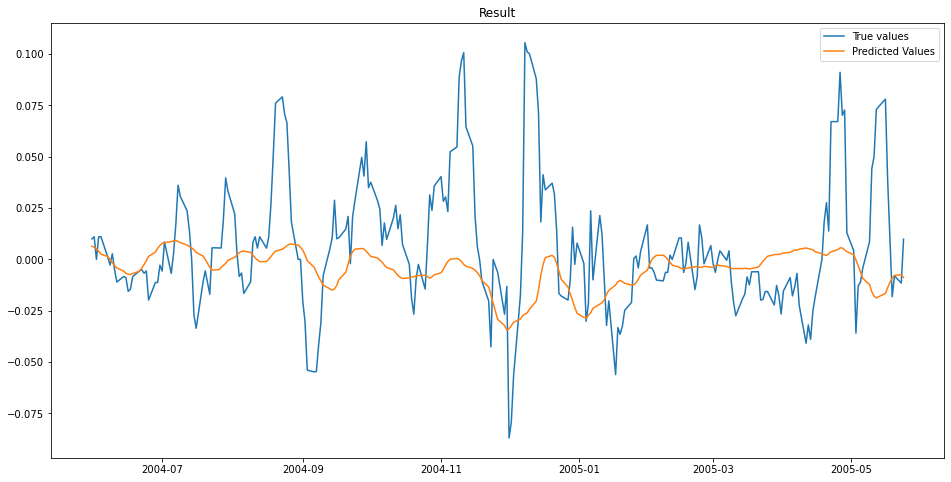


MSE: 0.0011616334447044753

Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 11.0637
Function value obtained: 0.0012
Current minimum: 0.0009
Iteration No: 51 started. Searching for the next optimal point.

learning rate: 0.00035696221331054826
num_input_nodes: 60
dropout: 0.15871059674378532
sequence_length : 152
batch_size: 205



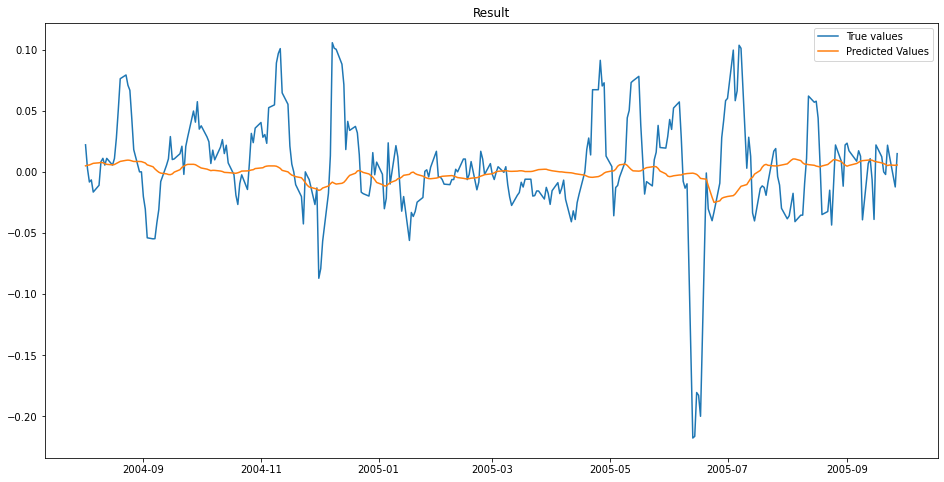


MSE: 0.0019215136139978833

Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 10.6792
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 52 started. Searching for the next optimal point.

learning rate: 0.0001188409223381412
num_input_nodes: 177
dropout: 0.21891156143998414
sequence_length : 168
batch_size: 175



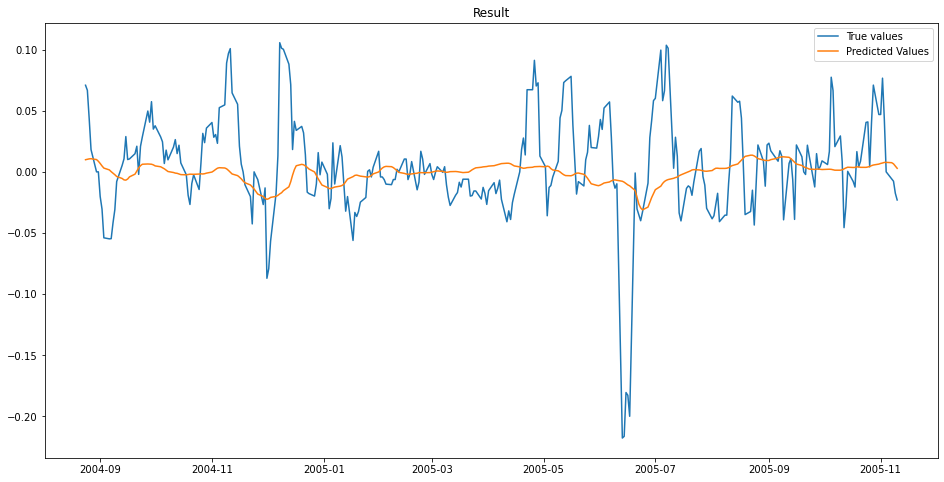


MSE: 0.0018461007942717966

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 17.0492
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 53 started. Searching for the next optimal point.

learning rate: 0.0033298625298422277
num_input_nodes: 48
dropout: 0.19978580796758103
sequence_length : 124
batch_size: 174



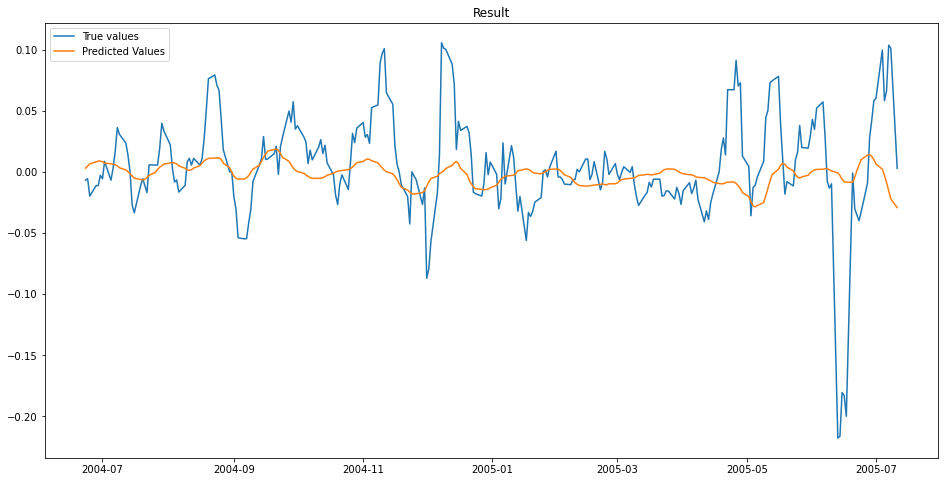


MSE: 0.0019105027187296096

Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 11.4419
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 54 started. Searching for the next optimal point.

learning rate: 0.00036027060747977226
num_input_nodes: 102
dropout: 0.04395199891507324
sequence_length : 157
batch_size: 103



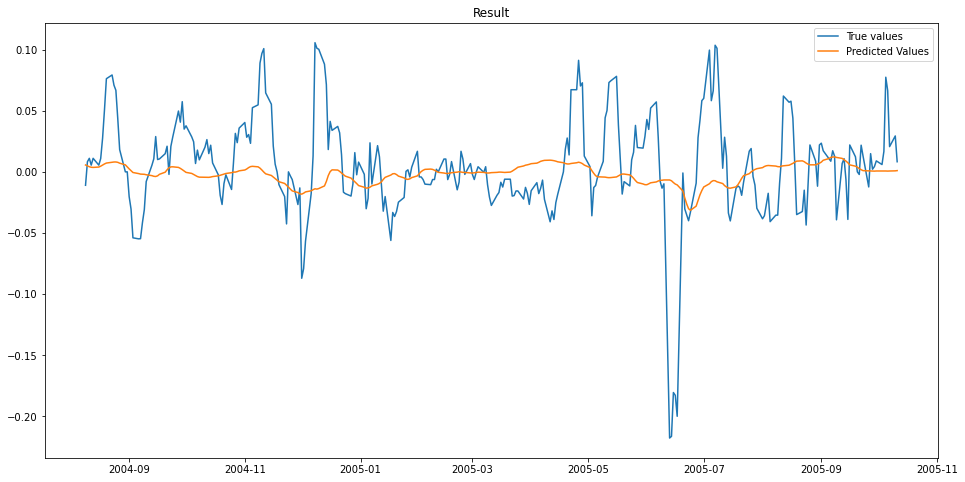


MSE: 0.0018805058019612994

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 15.5466
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 55 started. Searching for the next optimal point.

learning rate: 0.0007041754428186566
num_input_nodes: 24
dropout: 0.1808445203832612
sequence_length : 193
batch_size: 13



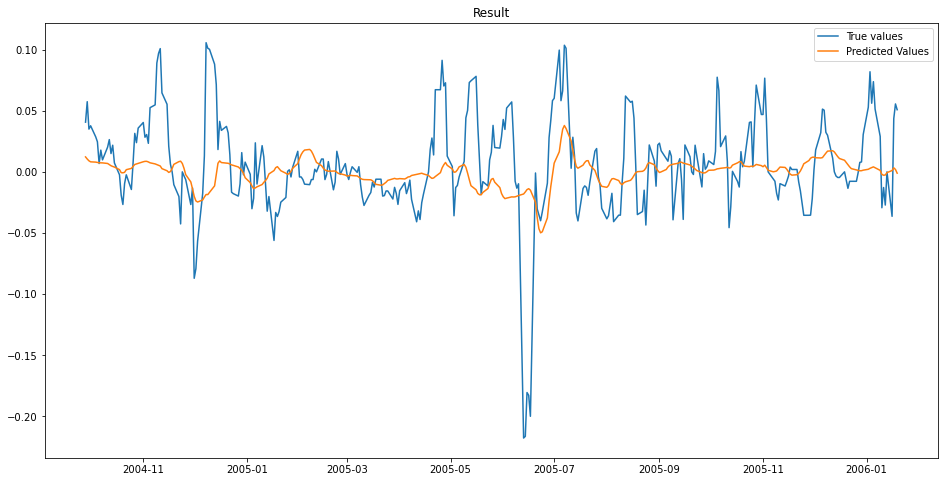


MSE: 0.001635838149657332

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 43.0095
Function value obtained: 0.0016
Current minimum: 0.0009
Iteration No: 56 started. Searching for the next optimal point.

learning rate: 0.009919908572416309
num_input_nodes: 75
dropout: 0.06993407026048219
sequence_length : 116
batch_size: 224



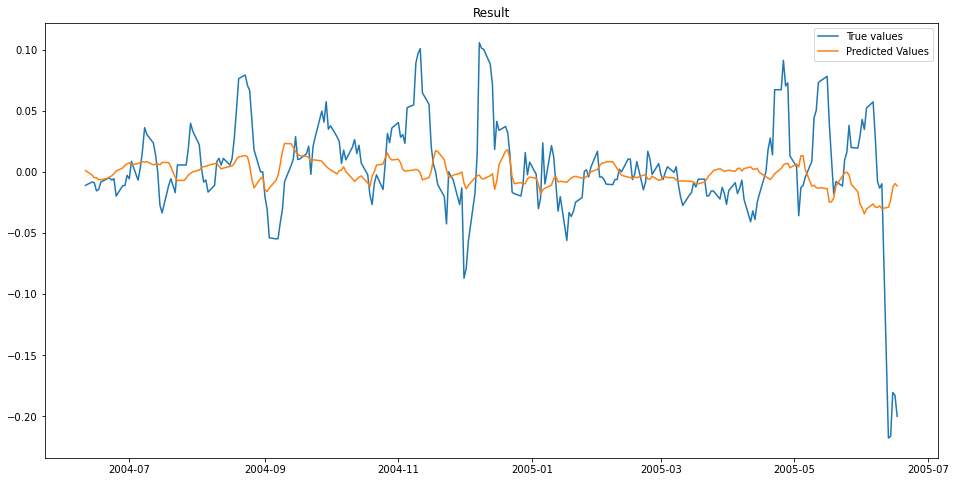


MSE: 0.0017668037978841205

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 11.0074
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 57 started. Searching for the next optimal point.

learning rate: 0.0001
num_input_nodes: 256
dropout: 0.25
sequence_length : 100
batch_size: 32



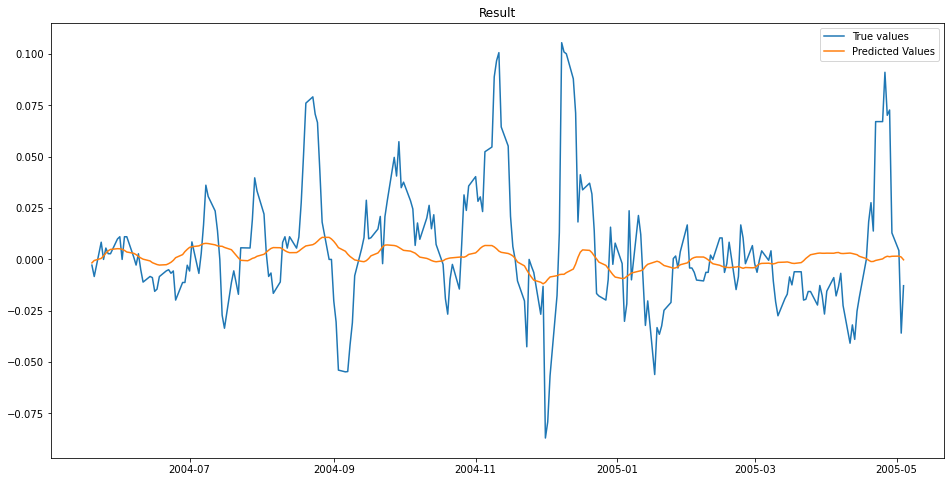


MSE: 0.0009329912896769312

Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 20.6053
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 58 started. Searching for the next optimal point.

learning rate: 0.0009519885287777707
num_input_nodes: 132
dropout: 0.029560473583090864
sequence_length : 146
batch_size: 176



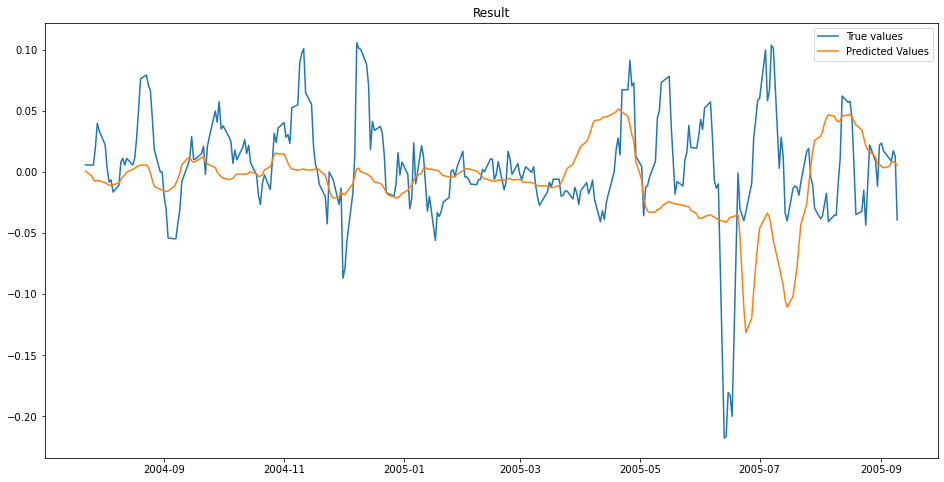


MSE: 0.0026368768023882594

Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 15.6694
Function value obtained: 0.0026
Current minimum: 0.0009
Iteration No: 59 started. Searching for the next optimal point.

learning rate: 0.0001
num_input_nodes: 97
dropout: 0.08766067312427217
sequence_length : 102
batch_size: 1



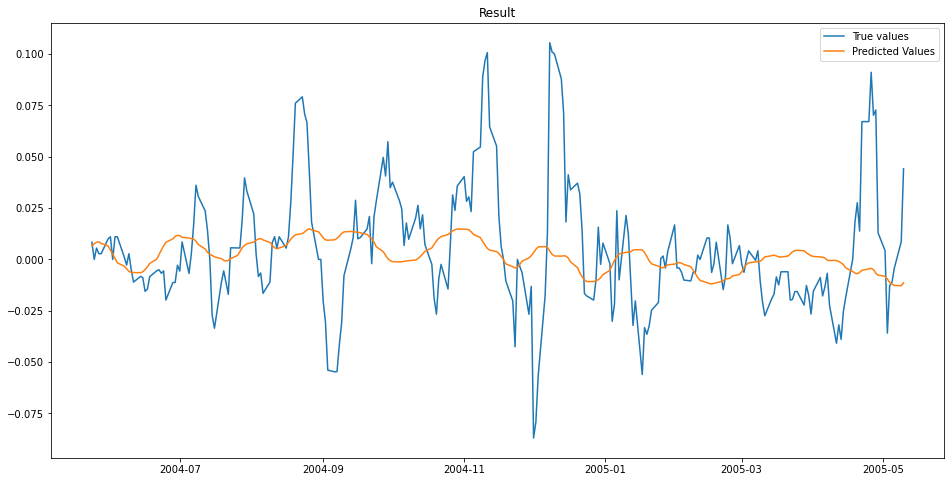


MSE: 0.000968143741015941

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 198.7041
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 60 started. Searching for the next optimal point.

learning rate: 0.00010180274711078338
num_input_nodes: 163
dropout: 0.07920302891584906
sequence_length : 176
batch_size: 158



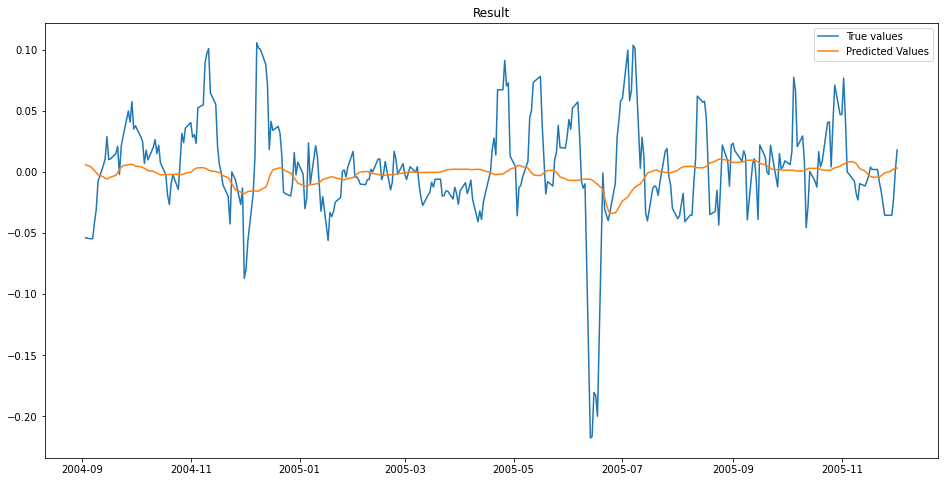


MSE: 0.001838442751260584

Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 16.9826
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 61 started. Searching for the next optimal point.

learning rate: 0.004601649422606682
num_input_nodes: 85
dropout: 0.015120516756848643
sequence_length : 148
batch_size: 188



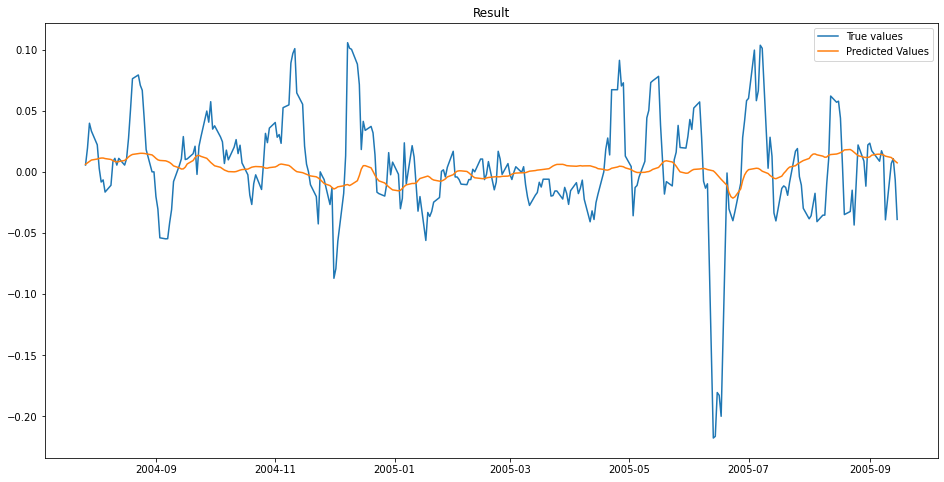


MSE: 0.001846136179556783

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 10.8767
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 62 started. Searching for the next optimal point.

learning rate: 0.003778761170677325
num_input_nodes: 207
dropout: 0.17932400172786384
sequence_length : 169
batch_size: 166



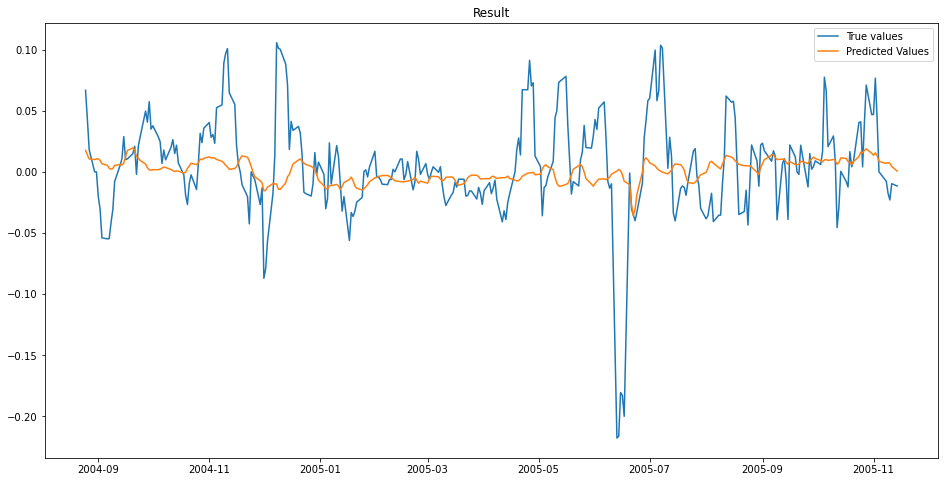


MSE: 0.001757986073845179

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 26.1852
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 63 started. Searching for the next optimal point.

learning rate: 0.006317569682726038
num_input_nodes: 256
dropout: 0.22668643102676886
sequence_length : 100
batch_size: 244



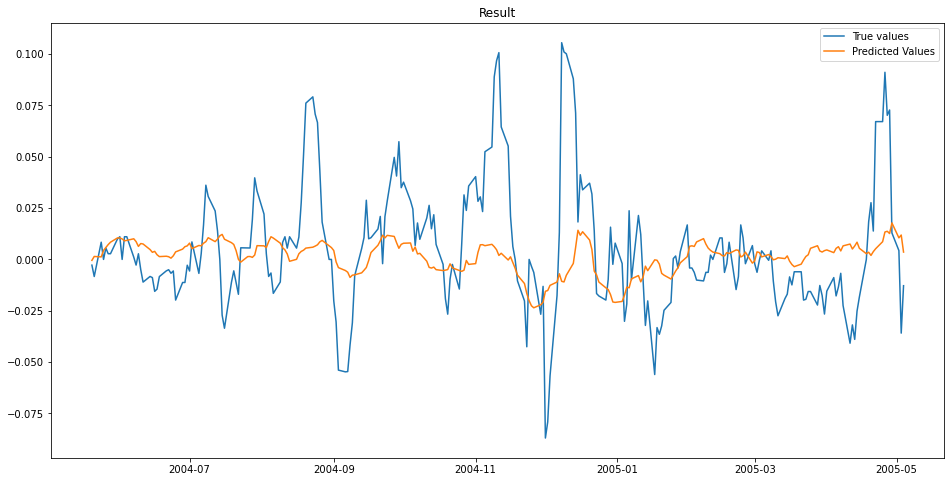


MSE: 0.0009116394714036151

Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 13.1144
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 64 started. Searching for the next optimal point.

learning rate: 0.005615343851370321
num_input_nodes: 256
dropout: 0.25
sequence_length : 100
batch_size: 7



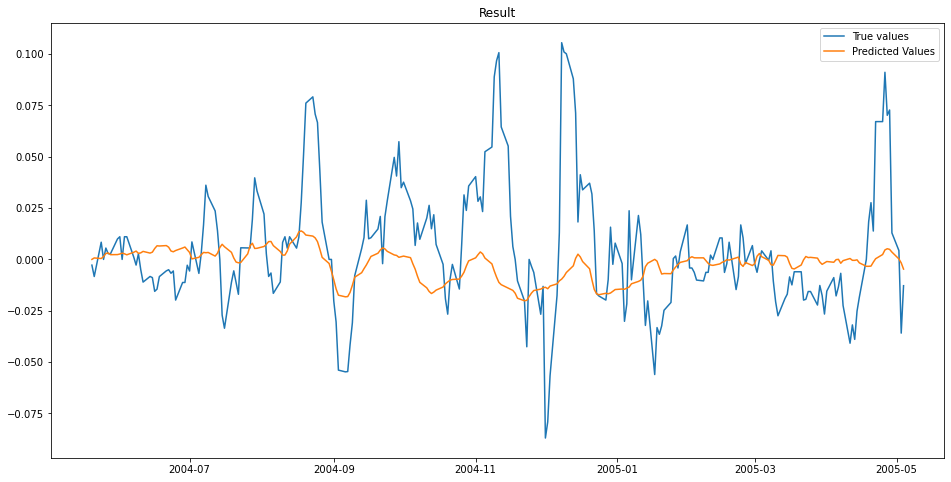


MSE: 0.0009726966157944722

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 55.3242
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 65 started. Searching for the next optimal point.

learning rate: 0.0031825100268068744
num_input_nodes: 256
dropout: 0.23016148506124542
sequence_length : 100
batch_size: 55



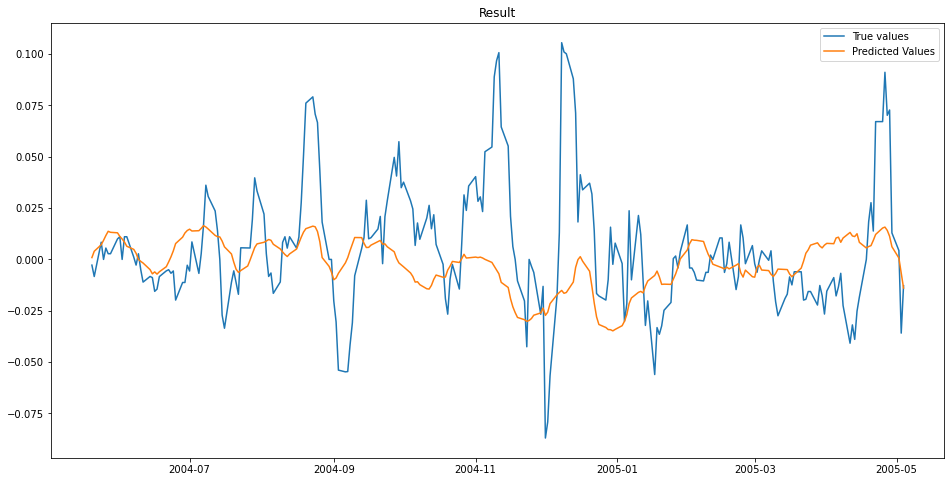


MSE: 0.001024000638352472

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 17.4768
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 66 started. Searching for the next optimal point.

learning rate: 0.00010041321891514692
num_input_nodes: 256
dropout: 0.22874935340807395
sequence_length : 103
batch_size: 30



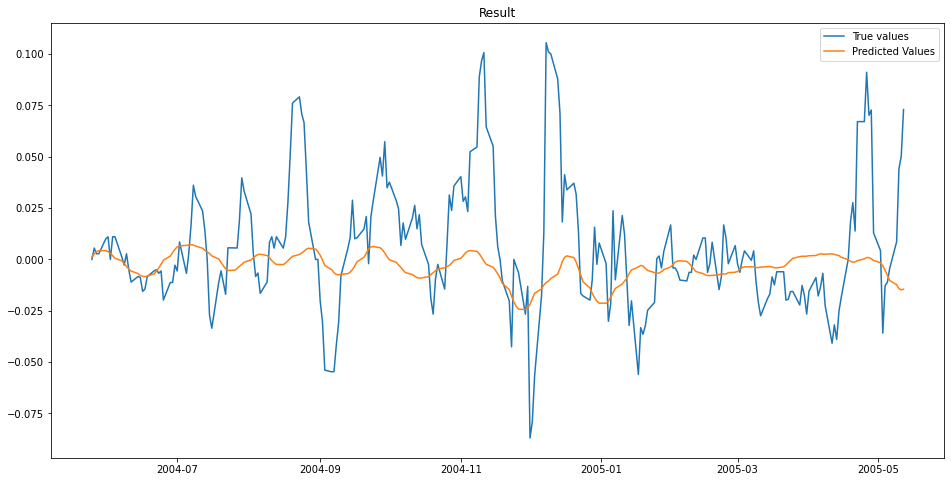


MSE: 0.0010224360085928522

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 22.0258
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 67 started. Searching for the next optimal point.

learning rate: 0.00014476706831299192
num_input_nodes: 203
dropout: 0.14726485363284803
sequence_length : 200
batch_size: 166



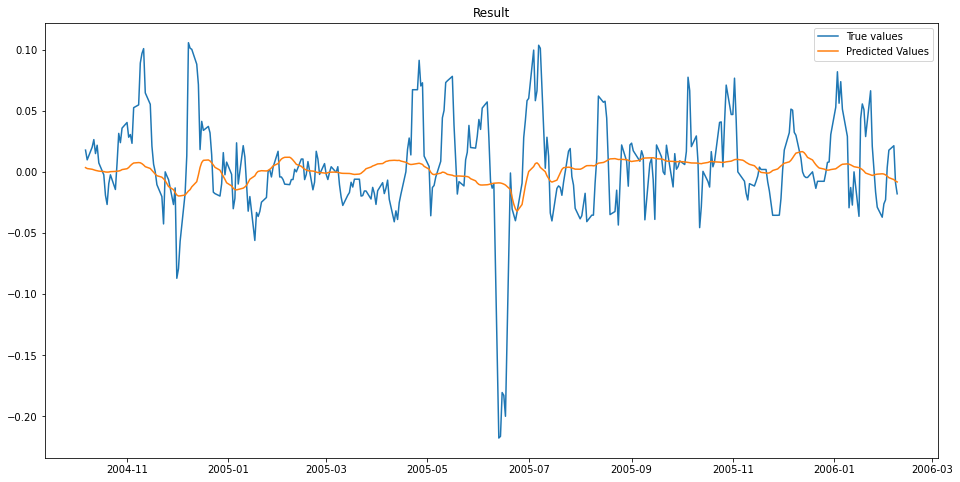


MSE: 0.0016439535097098911

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 28.3962
Function value obtained: 0.0016
Current minimum: 0.0009
Iteration No: 68 started. Searching for the next optimal point.

learning rate: 0.0001703614412866861
num_input_nodes: 254
dropout: 0.19476335722100108
sequence_length : 100
batch_size: 245



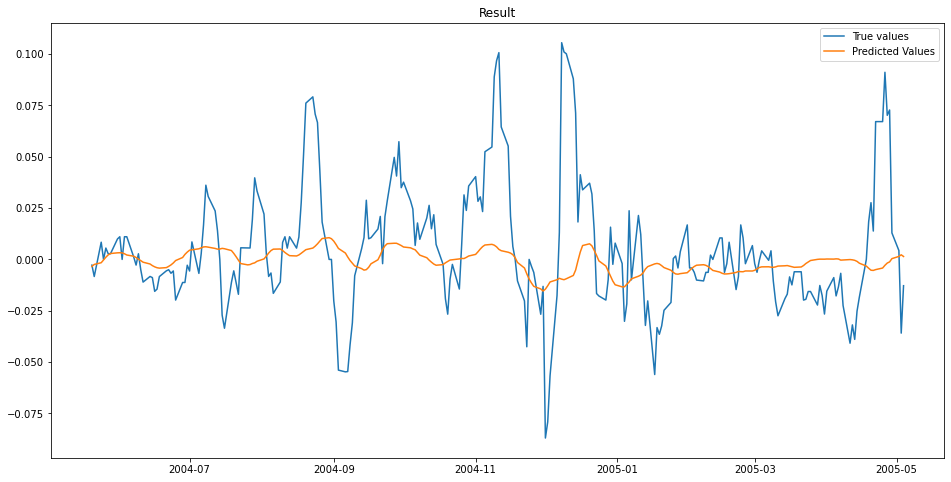


MSE: 0.0009441952284502285

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 12.9390
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 69 started. Searching for the next optimal point.

learning rate: 0.00022898042712449123
num_input_nodes: 142
dropout: 0.017850679904295817
sequence_length : 167
batch_size: 36



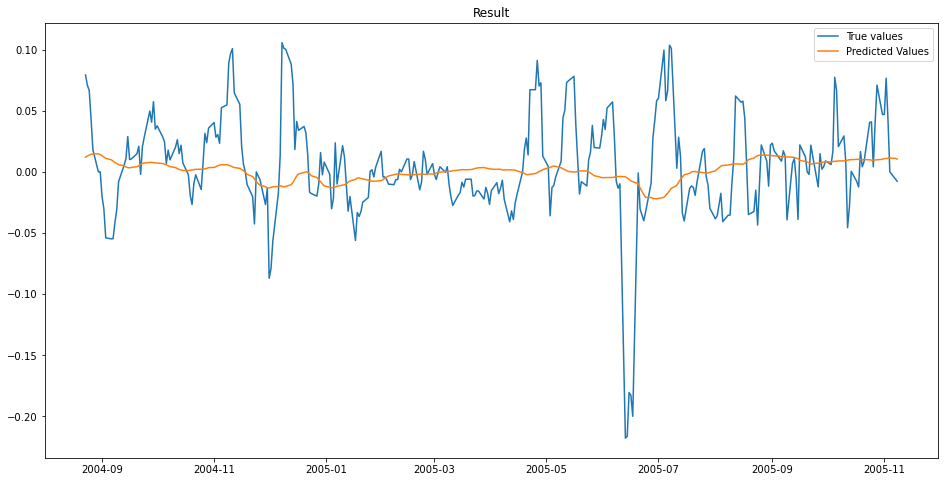


MSE: 0.0018818075573692622

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 21.9564
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 70 started. Searching for the next optimal point.

learning rate: 0.0074679861474208084
num_input_nodes: 256
dropout: 0.24194006098634352
sequence_length : 100
batch_size: 11



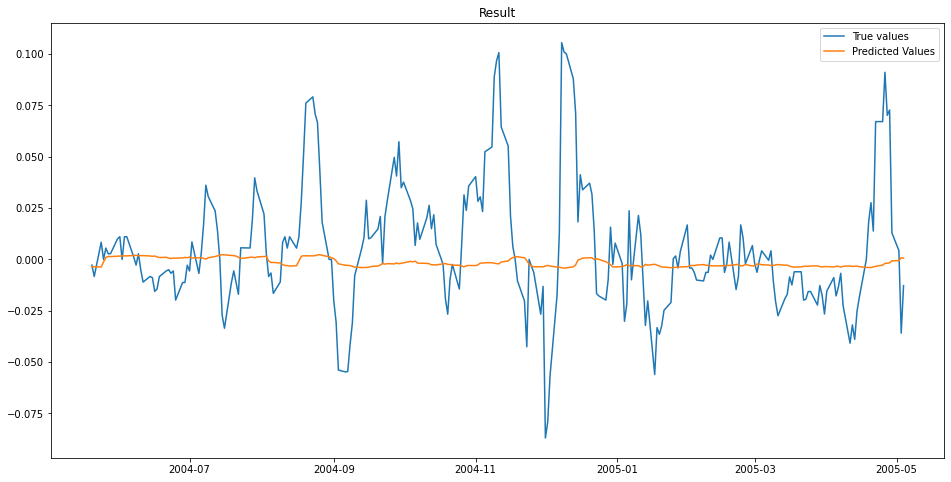


MSE: 0.0009990847036242913

Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 49.5790
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 71 started. Searching for the next optimal point.

learning rate: 0.0005385491859024194
num_input_nodes: 256
dropout: 0.2449997502793498
sequence_length : 103
batch_size: 195



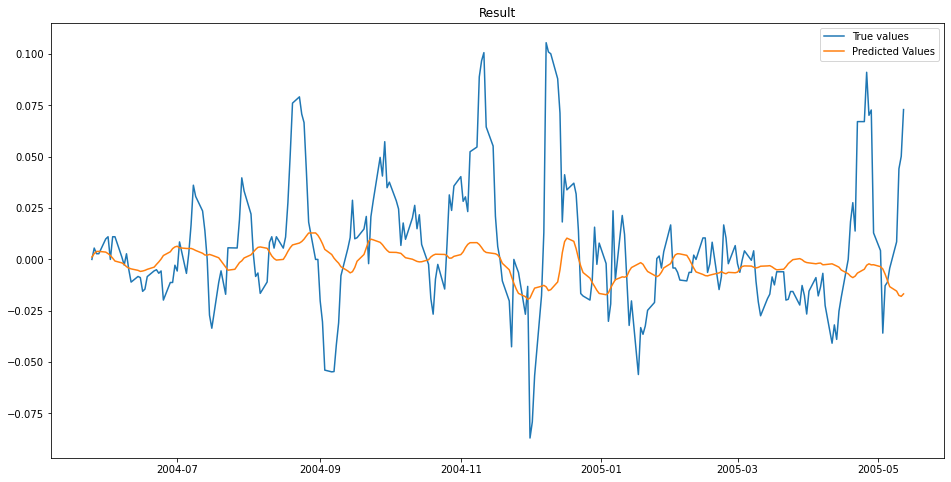


MSE: 0.0010043896573234707

Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 14.2500
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 72 started. Searching for the next optimal point.

learning rate: 0.001934714882000995
num_input_nodes: 14
dropout: 0.1496472888041074
sequence_length : 176
batch_size: 40



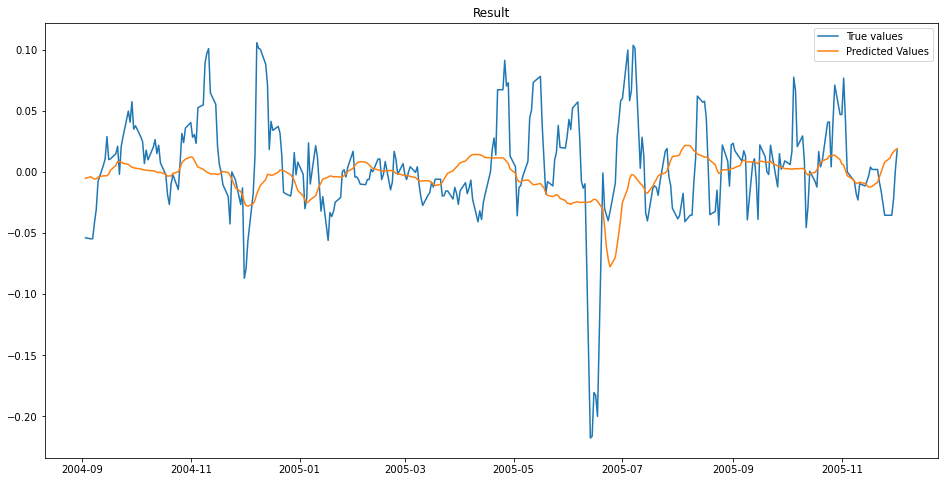


MSE: 0.0018209223696893917

Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 18.9679
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 73 started. Searching for the next optimal point.

learning rate: 0.0001960116571995673
num_input_nodes: 238
dropout: 0.016410823138326067
sequence_length : 128
batch_size: 216



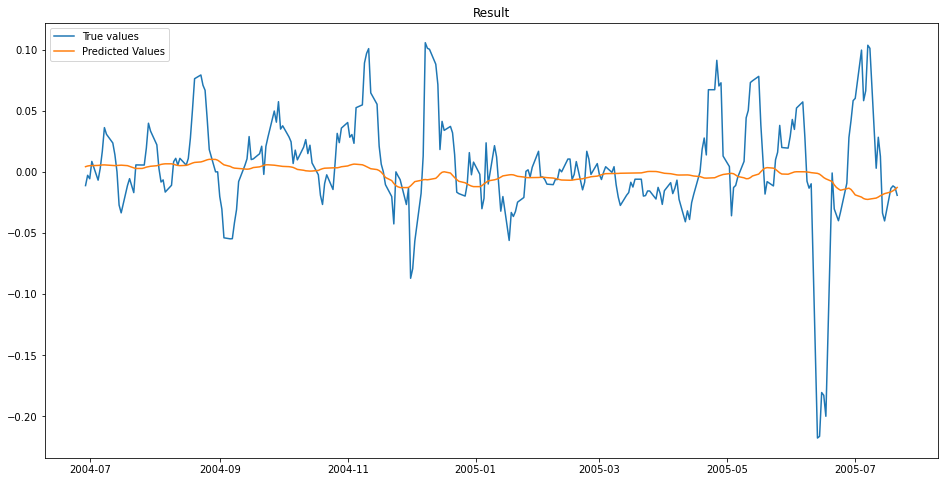


MSE: 0.001980671335023965

Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 13.6447
Function value obtained: 0.0020
Current minimum: 0.0009
Iteration No: 74 started. Searching for the next optimal point.

learning rate: 0.0016564469777783752
num_input_nodes: 168
dropout: 0.10476539484311784
sequence_length : 179
batch_size: 71



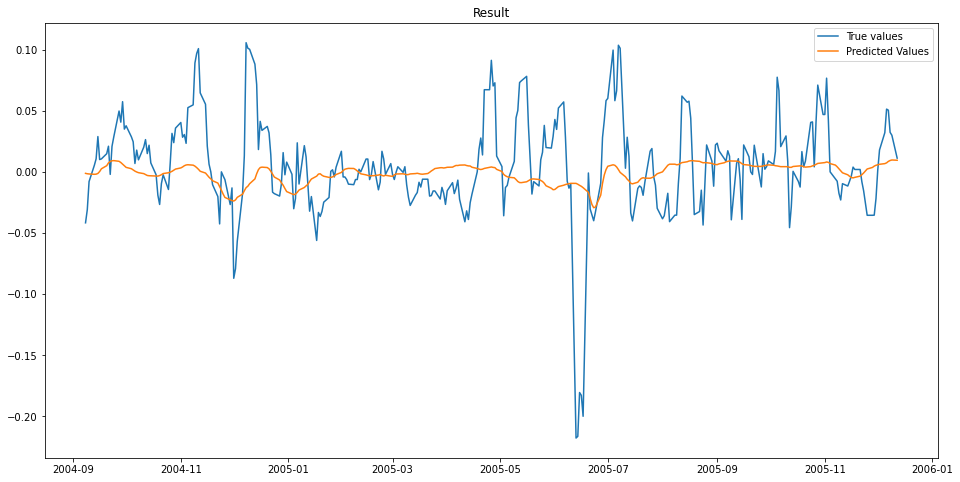


MSE: 0.0016659358077394824

Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 18.5537
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 75 started. Searching for the next optimal point.

learning rate: 0.00020458807202446572
num_input_nodes: 88
dropout: 0.2289375289856191
sequence_length : 199
batch_size: 222



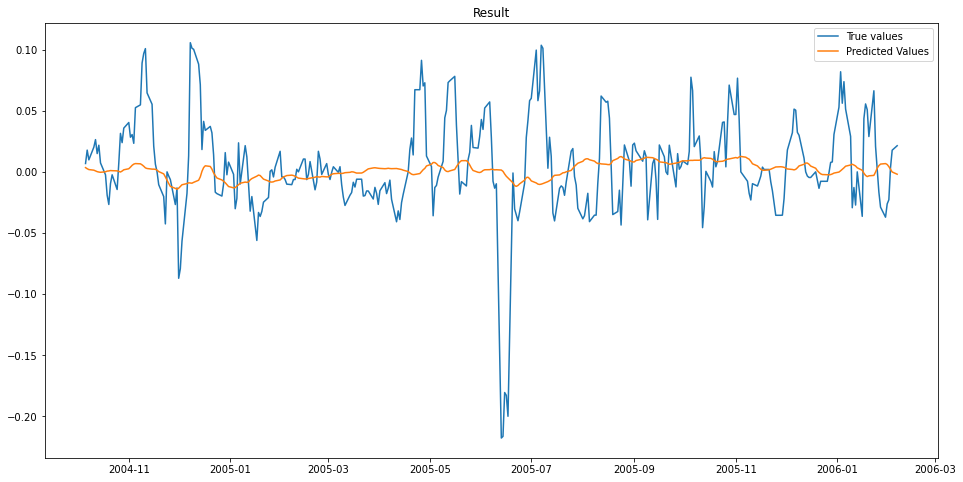


MSE: 0.0017464873129461062

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 12.8001
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 76 started. Searching for the next optimal point.

learning rate: 0.00936354814193516
num_input_nodes: 58
dropout: 0.018650182734457125
sequence_length : 177
batch_size: 155



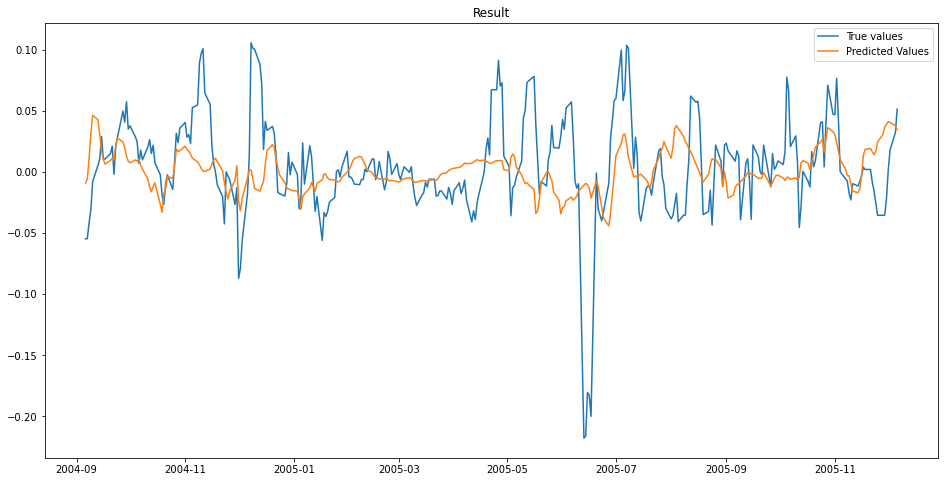


MSE: 0.001773566824160544

Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 16.6929
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 77 started. Searching for the next optimal point.

learning rate: 0.0006277318630327672
num_input_nodes: 170
dropout: 0.17310481009819254
sequence_length : 195
batch_size: 179



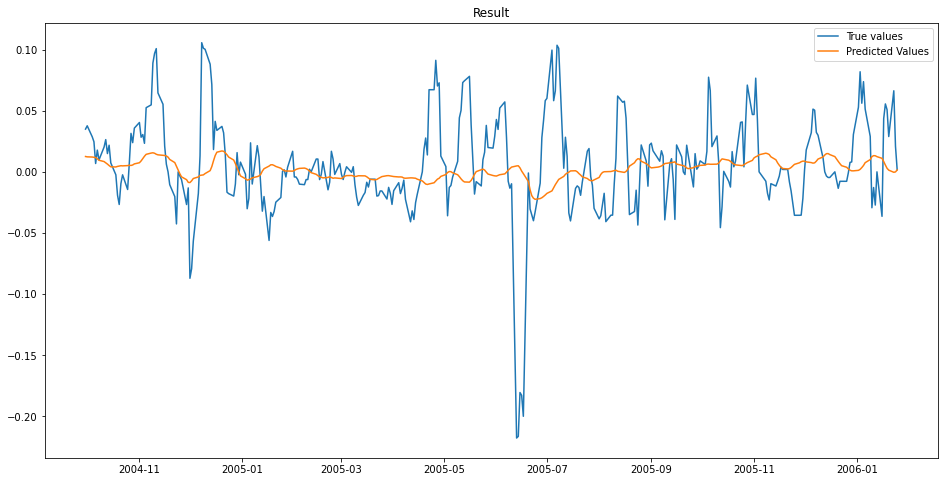


MSE: 0.0017766467976410994

Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 15.6361
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 78 started. Searching for the next optimal point.

learning rate: 0.002284909284241205
num_input_nodes: 256
dropout: 0.024851576567478748
sequence_length : 103
batch_size: 235



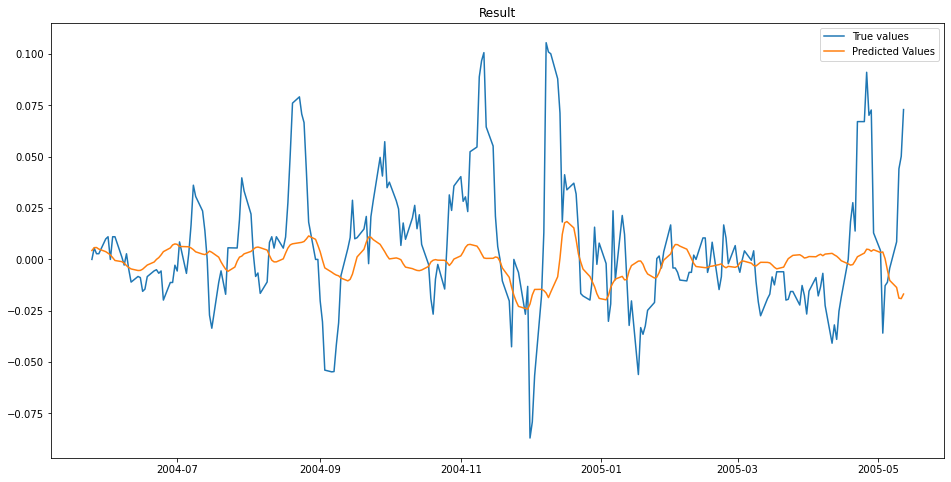


MSE: 0.000990987602240545

Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 12.8702
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 79 started. Searching for the next optimal point.

learning rate: 0.0024768316121782804
num_input_nodes: 166
dropout: 0.015770349364863216
sequence_length : 128
batch_size: 83



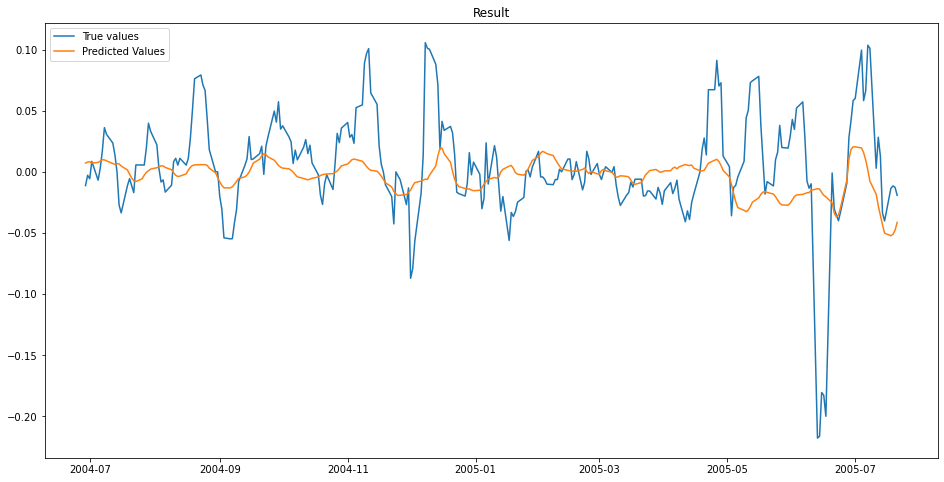


MSE: 0.0018525560481376492

Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 17.9314
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 80 started. Searching for the next optimal point.

learning rate: 0.0011848875333369338
num_input_nodes: 148
dropout: 0.1820547760128416
sequence_length : 186
batch_size: 112



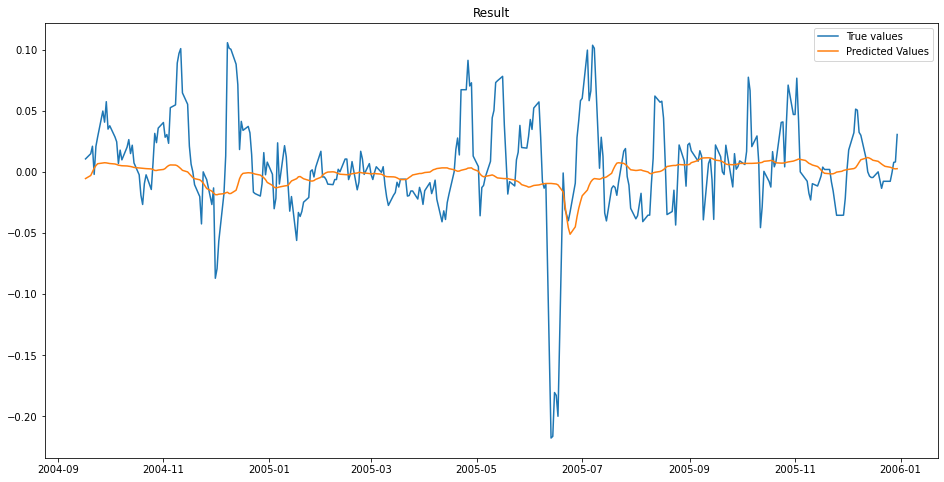


MSE: 0.00171902529765948

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 15.8651
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 81 started. Searching for the next optimal point.

learning rate: 0.0011423909268846318
num_input_nodes: 256
dropout: 0.04361828343006887
sequence_length : 100
batch_size: 89



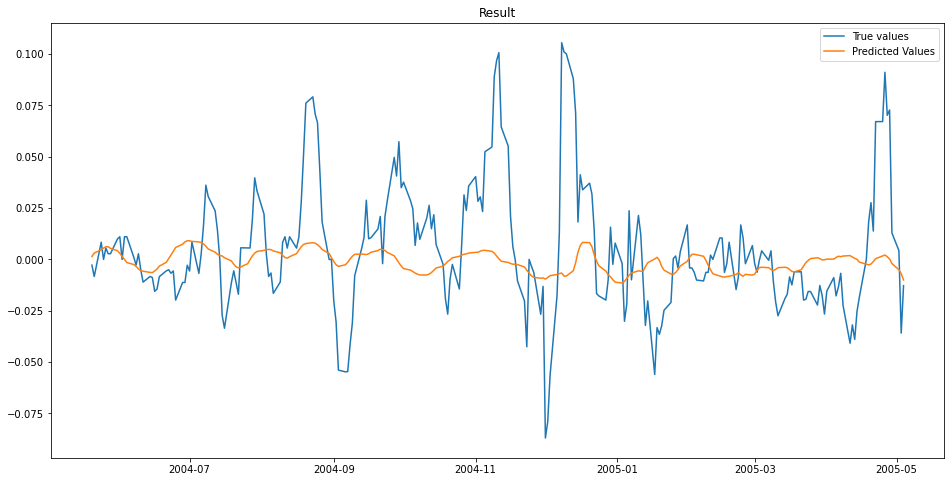


MSE: 0.0009487698407544537

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 16.3422
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 82 started. Searching for the next optimal point.

learning rate: 0.002827388517269168
num_input_nodes: 209
dropout: 0.17279149398322147
sequence_length : 117
batch_size: 247



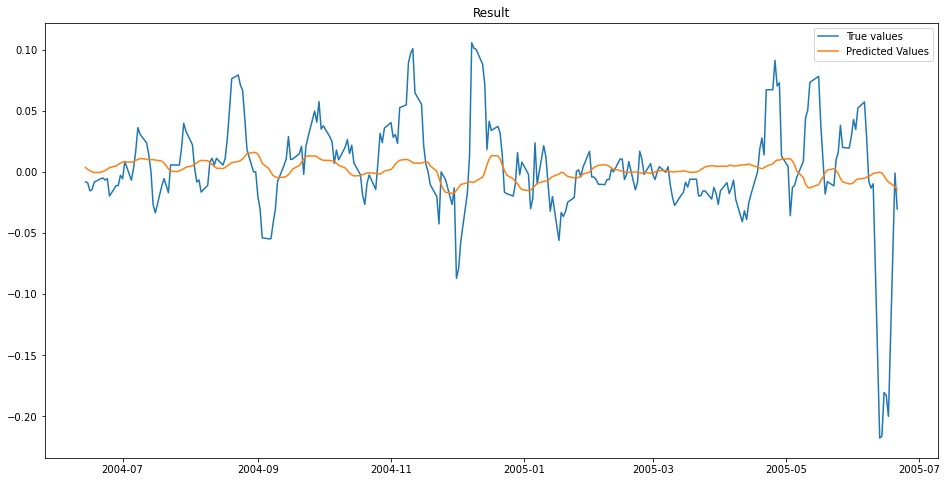


MSE: 0.0017528371750233822

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 12.3126
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 83 started. Searching for the next optimal point.

learning rate: 0.0010175461262211167
num_input_nodes: 159
dropout: 0.21268918654950092
sequence_length : 117
batch_size: 96



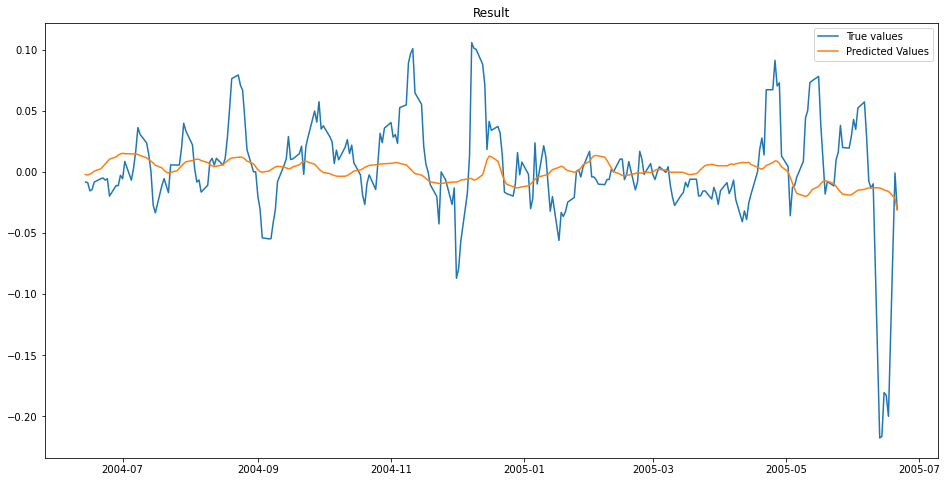


MSE: 0.0017562795941542505

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 16.2105
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 84 started. Searching for the next optimal point.

learning rate: 0.0019620658397930023
num_input_nodes: 247
dropout: 0.0796603052293783
sequence_length : 141
batch_size: 82



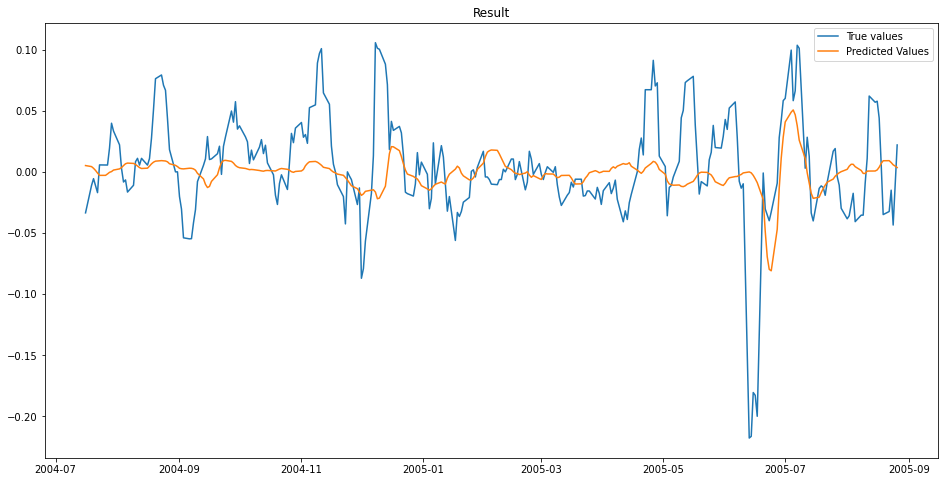


MSE: 0.0018241931550017432

Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 22.7543
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 85 started. Searching for the next optimal point.

learning rate: 0.008043191210903316
num_input_nodes: 42
dropout: 0.22844898929603968
sequence_length : 113
batch_size: 68



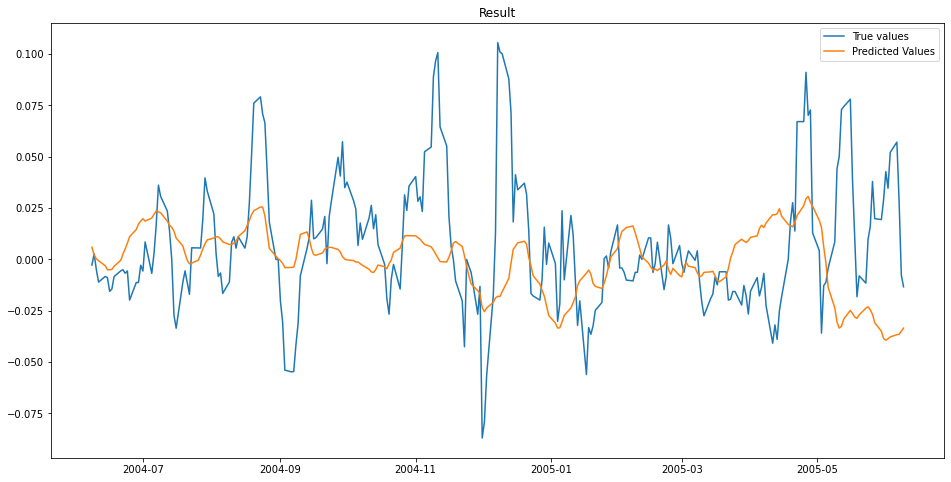


MSE: 0.0012794188392225253

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 13.2285
Function value obtained: 0.0013
Current minimum: 0.0009
Iteration No: 86 started. Searching for the next optimal point.

learning rate: 0.0038009778724640993
num_input_nodes: 232
dropout: 0.12491961823757344
sequence_length : 136
batch_size: 71



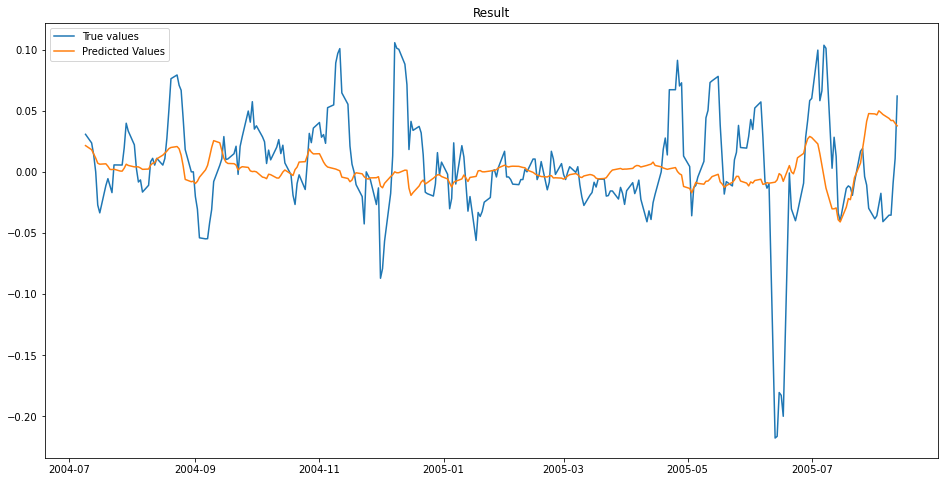


MSE: 0.0020135169264878087

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 21.0293
Function value obtained: 0.0020
Current minimum: 0.0009
Iteration No: 87 started. Searching for the next optimal point.

learning rate: 0.005333059284877444
num_input_nodes: 28
dropout: 0.10729957267690465
sequence_length : 105
batch_size: 246



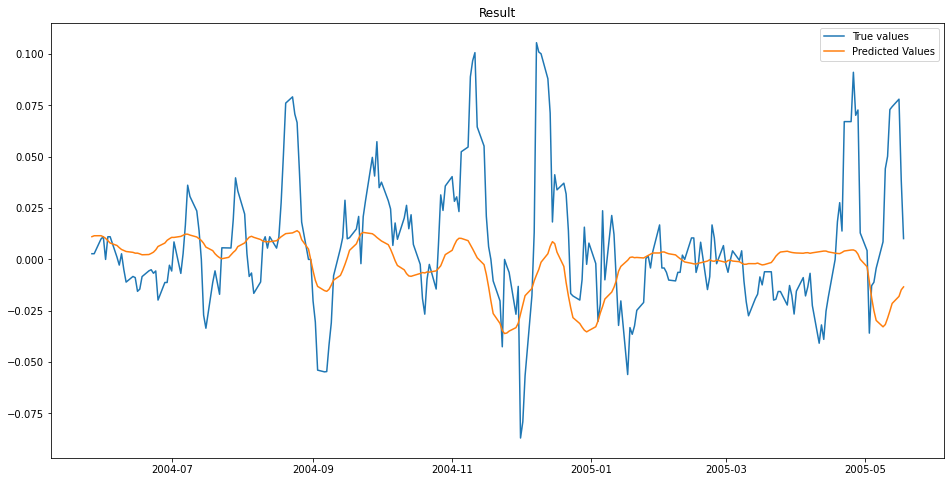


MSE: 0.0010523443236646335

Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 9.4541
Function value obtained: 0.0011
Current minimum: 0.0009
Iteration No: 88 started. Searching for the next optimal point.

learning rate: 0.0001477443660864128
num_input_nodes: 152
dropout: 0.13384018712408904
sequence_length : 181
batch_size: 59



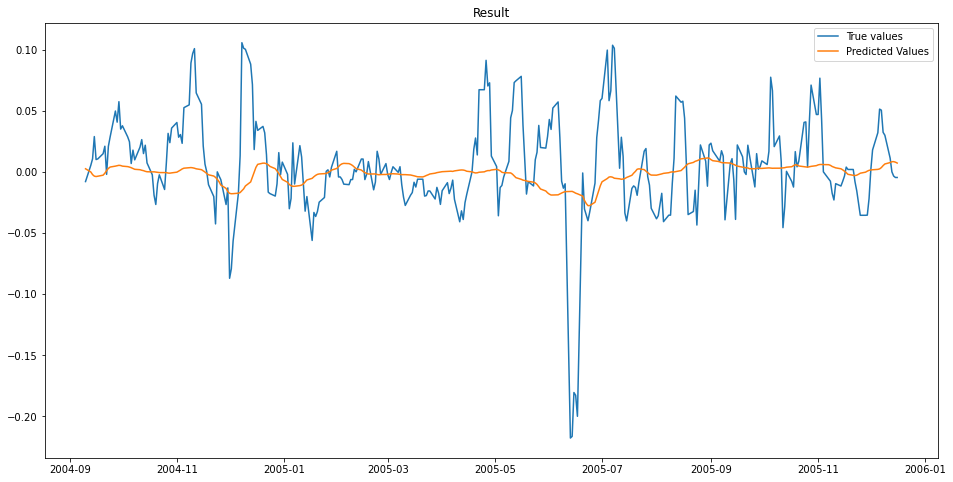


MSE: 0.0016836029634602428

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 20.2733
Function value obtained: 0.0017
Current minimum: 0.0009
Iteration No: 89 started. Searching for the next optimal point.

learning rate: 0.0008445418294947695
num_input_nodes: 13
dropout: 0.042389148320655434
sequence_length : 100
batch_size: 44



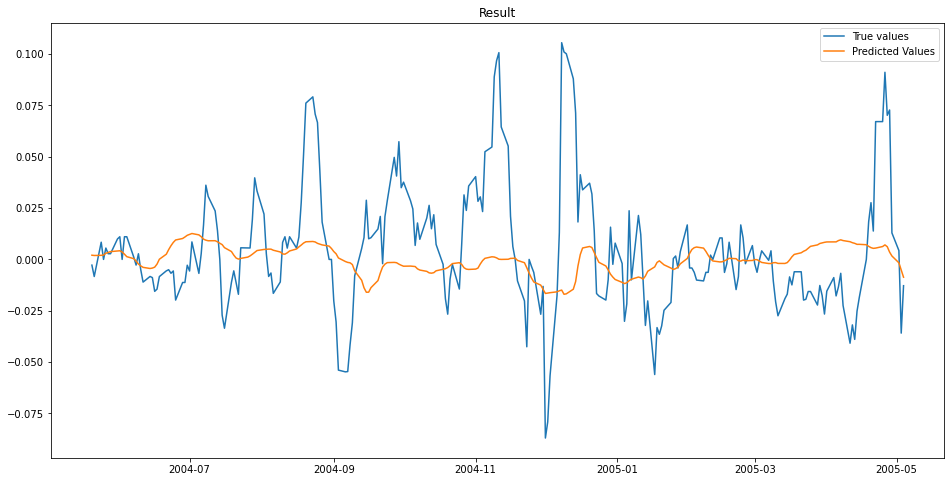


MSE: 0.0010258314621626585

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 14.1384
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 90 started. Searching for the next optimal point.

learning rate: 0.003733473307491649
num_input_nodes: 106
dropout: 0.1397351285801814
sequence_length : 131
batch_size: 27



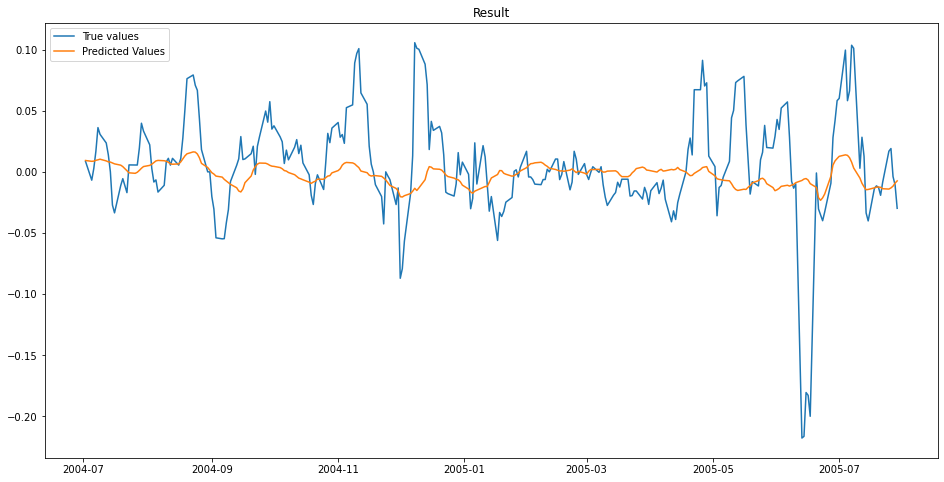


MSE: 0.0018303869658389948

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 25.0281
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 91 started. Searching for the next optimal point.

learning rate: 0.002885109615121379
num_input_nodes: 256
dropout: 0.17584267519233884
sequence_length : 100
batch_size: 248



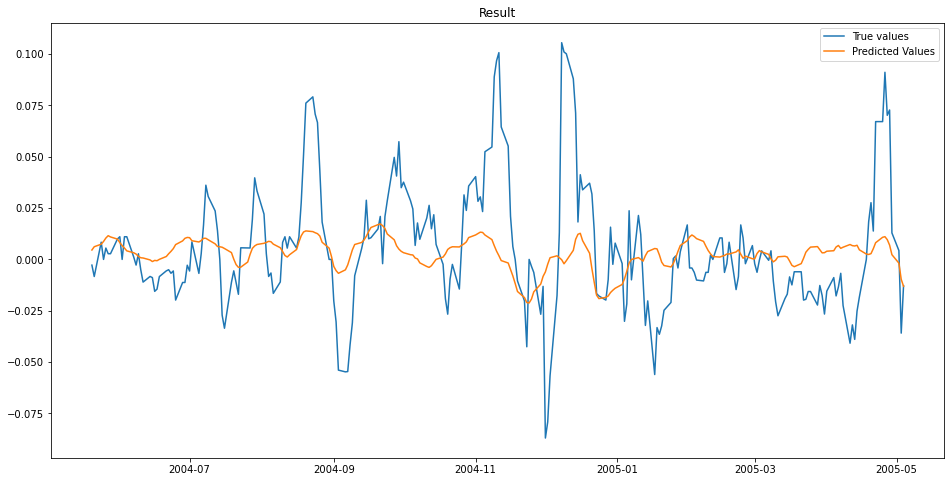


MSE: 0.0008742353713008284

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 13.3046
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 92 started. Searching for the next optimal point.

learning rate: 0.00013559023717201642
num_input_nodes: 253
dropout: 0.19122942692579825
sequence_length : 100
batch_size: 17



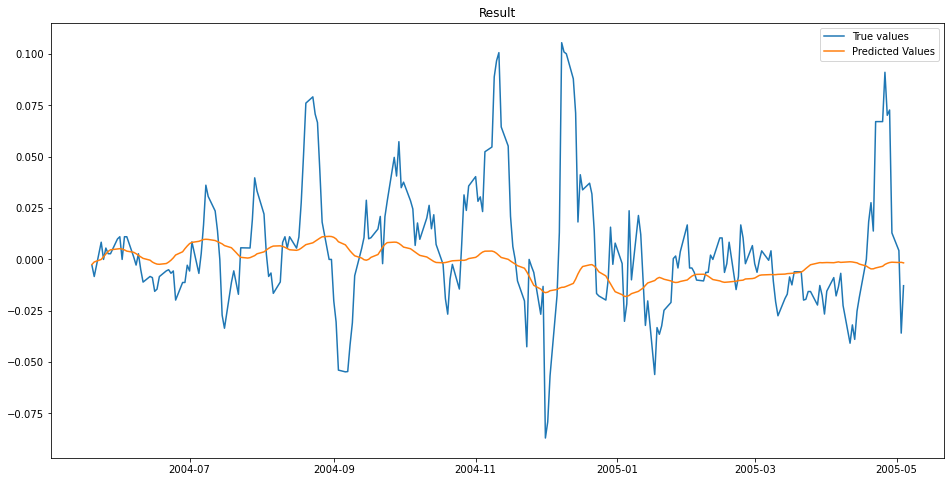


MSE: 0.0009745153288501562

Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 37.7030
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 93 started. Searching for the next optimal point.

learning rate: 0.001454010611221609
num_input_nodes: 52
dropout: 0.09308903147973126
sequence_length : 116
batch_size: 182



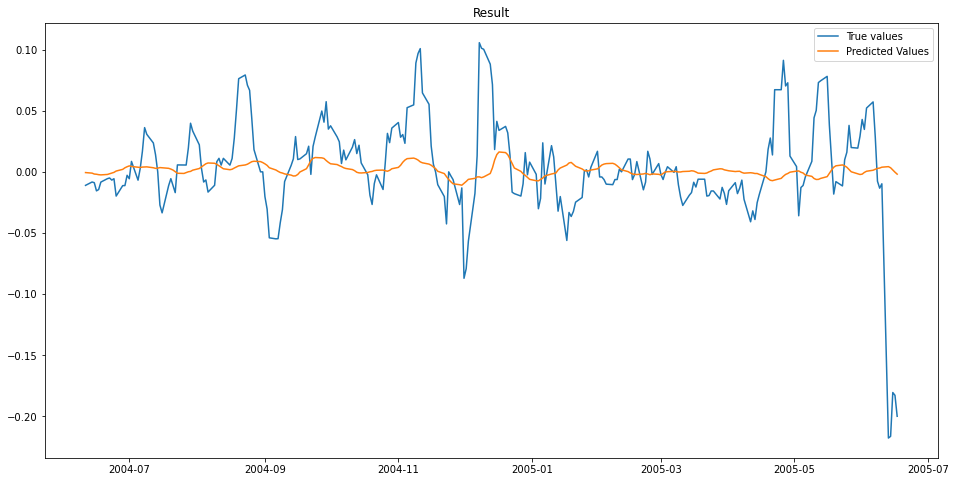


MSE: 0.0017800965868816853

Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 10.7822
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 94 started. Searching for the next optimal point.

learning rate: 0.00013922483491784666
num_input_nodes: 57
dropout: 0.00809265959299685
sequence_length : 154
batch_size: 51



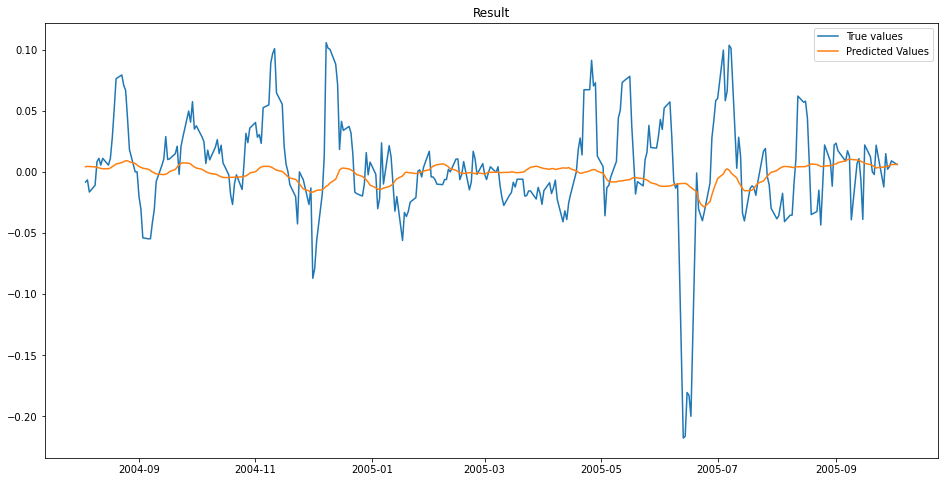


MSE: 0.001804873456255537

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 19.3944
Function value obtained: 0.0018
Current minimum: 0.0009
Iteration No: 95 started. Searching for the next optimal point.

learning rate: 0.0032362322960012785
num_input_nodes: 256
dropout: 0.25
sequence_length : 111
batch_size: 250



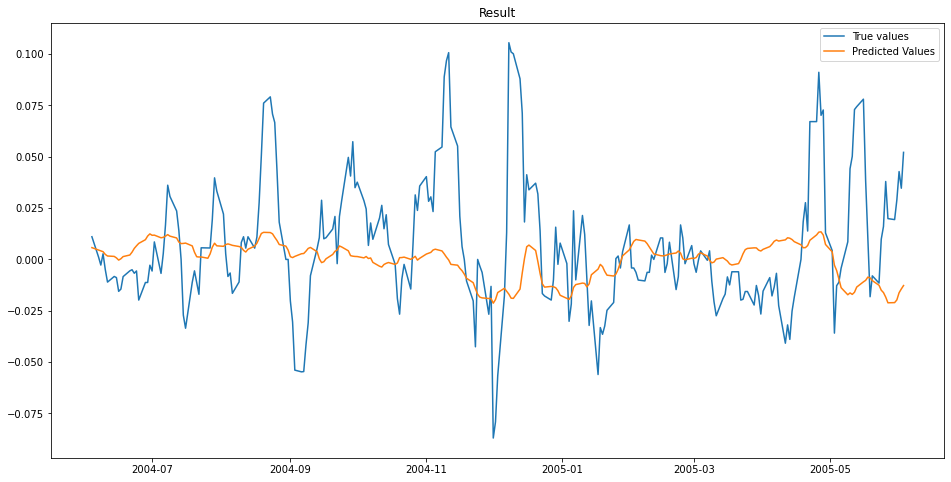


MSE: 0.001133808632987255

Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 14.1036
Function value obtained: 0.0011
Current minimum: 0.0009
Iteration No: 96 started. Searching for the next optimal point.

learning rate: 0.0002696781465874431
num_input_nodes: 5
dropout: 0.25
sequence_length : 101
batch_size: 1



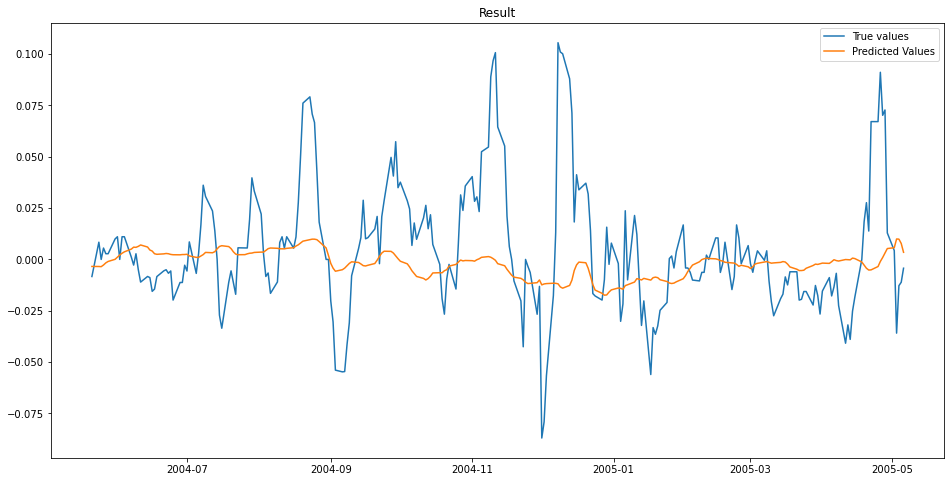


MSE: 0.000986985731640259

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 244.6635
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 97 started. Searching for the next optimal point.

learning rate: 0.0002890880806223456
num_input_nodes: 237
dropout: 0.12307850504510529
sequence_length : 160
batch_size: 232



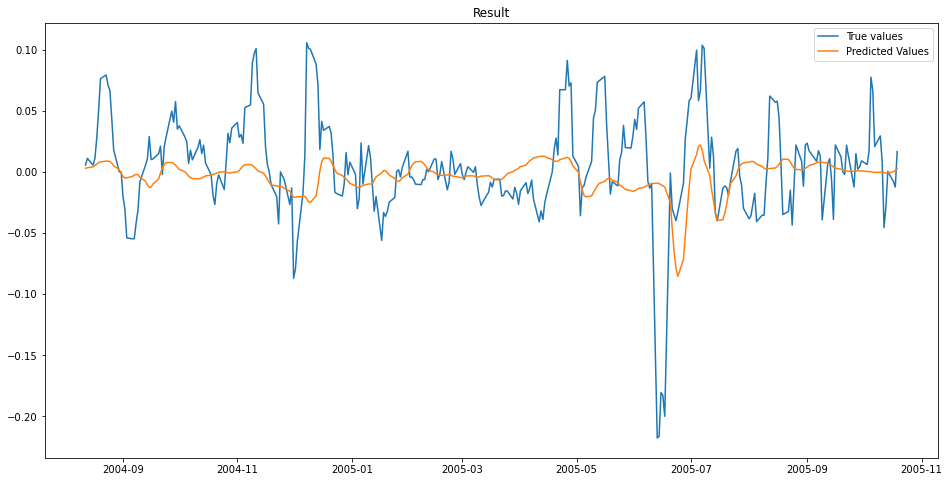


MSE: 0.0018839711430914917

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 21.3577
Function value obtained: 0.0019
Current minimum: 0.0009
Iteration No: 98 started. Searching for the next optimal point.

learning rate: 0.00034071149169963196
num_input_nodes: 256
dropout: 0.2116772194302655
sequence_length : 101
batch_size: 250



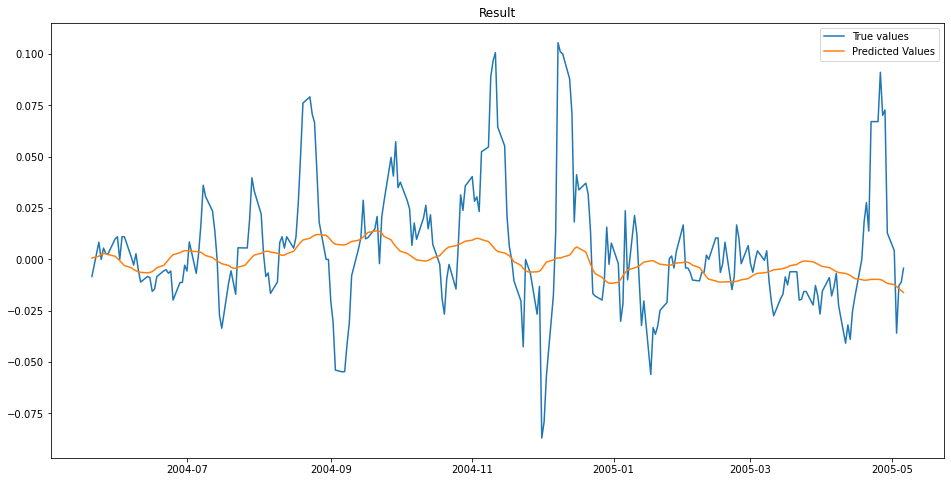


MSE: 0.0009202003269843987

Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 12.1905
Function value obtained: 0.0009
Current minimum: 0.0009
Iteration No: 99 started. Searching for the next optimal point.

learning rate: 0.0001
num_input_nodes: 256
dropout: 0.0
sequence_length : 104
batch_size: 250



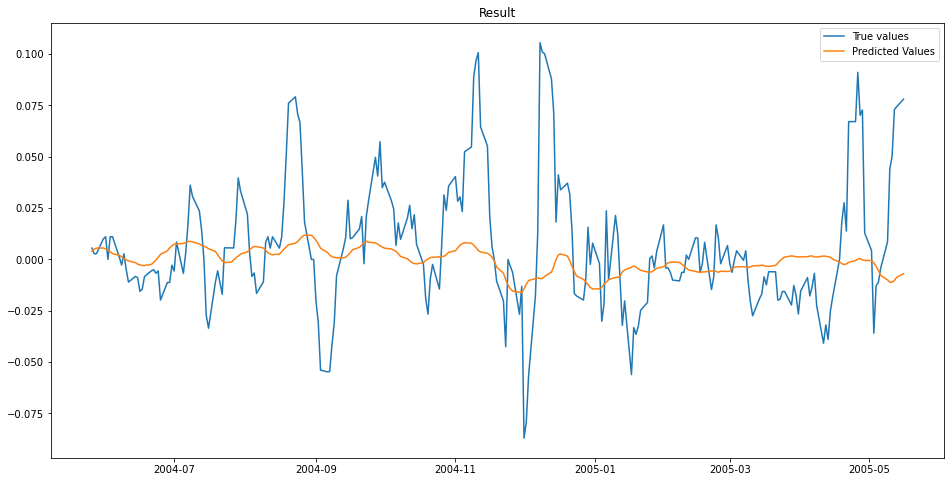


MSE: 0.0010203007965858084

Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 13.1210
Function value obtained: 0.0010
Current minimum: 0.0009
Iteration No: 100 started. Searching for the next optimal point.

learning rate: 0.00011721775002593032
num_input_nodes: 39
dropout: 0.12976722869907892
sequence_length : 174
batch_size: 136



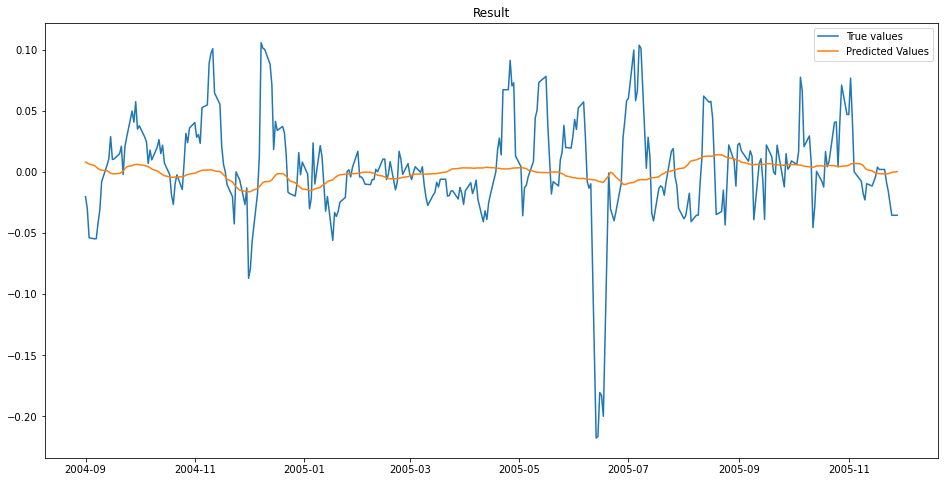


MSE: 0.0017693840629792632

Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 14.6534
Function value obtained: 0.0018
Current minimum: 0.0009


In [10]:
gp_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_jobs=-1,
                            n_random_starts=10,
                            verbose=True,
                            x0=default_parameters,
                            random_state=randseed)

**Summary of configurations and results**

In [11]:
res = pd.concat([pd.DataFrame(gp_result.x_iters, columns = ['learning_rate', 'num_input_nodes', 'dropout', 'sequencelength', 'batch_size']),(pd.Series(gp_result.func_vals, name="mse"))], axis=1)
res = res.sort_values(by='mse')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(res)

learning_rate  num_input_nodes   dropout  sequencelength  batch_size  \
90       0.002885              256  0.175843             100         248   
20       0.010000               22  0.250000             100           1   
62       0.006318              256  0.226686             100         244   
97       0.000341              256  0.211677             101         250   
19       0.010000              221  0.118691             100         209   
56       0.000100              256  0.250000             100          32   
36       0.000125              256  0.250000             100         124   
67       0.000170              254  0.194763             100         245   
3        0.000130              186  0.234638             100         248   
80       0.001142              256  0.043618             100          89   
17       0.000100              256  0.000000             100         168   
48       0.005546              130  0.250000             102         250   
34       0.006167              256  0.250000             100          63   
58       0.000100               97  0.087661             102           1   
63       0.005615              256  0.250000             100           7   
35       0.000290              256  0.250000             103         168   
91       0.000136              253  0.191229             100          17   
4        0.001718              159  0.001767             102         132   
95       0.000270                5  0.250000             101           1   
77       0.002285              256  0.024852             103         235   
69       0.007468              256  0.241940             100          11   
70       0.000539              256  0.245000             103         195   
42       0.001648              256  0.250000             100           1   
98       0.000100              256  0.000000             104         250   
23       0.010000              208  0.032491             100           1   
65       0.000100              256  0.228749             103          30   
12       0.001106              247  0.239615             105          66   
64       0.003183              256  0.230161             100          55   
88       0.000845               13  0.042389             100          44   
21       0.010000               53  0.250000             110         250   
18       0.000138              233  0.000000             107         169   
86       0.005333               28  0.107300             105         246   
94       0.003236              256  0.250000             111         250   
24       0.000286              124  0.198719             112          17   
43       0.000160              181  0.086045             110          34   
49       0.001520              144  0.129239             107         181   
2        0.000158              120  0.083427             114         163   
25       0.006291                5  0.000000             100         250   
39       0.000250              244  0.119440             114         166   
29       0.002007               53  0.159039             110         151   
84       0.008043               42  0.228449             113          68   
37       0.001385              149  0.045949             114          57   
44       0.002576              217  0.180083             187          33   
54       0.000704               24  0.180845             193          13   
66       0.000145              203  0.147265             200         166   
73       0.001656              168  0.104765             179          71   
87       0.000148              152  0.133840             181          59   
0        0.000300              256  0.200000             200          32   
28       0.000434              207  0.051118             187         195   
31       0.000863              127  0.008028             176         126   
79       0.001185              148  0.182055             186         112   
47       0.000984              216  0.091940        